# 1 Preliminaries

## 1.1 Get data

In [ ]:
!gdown 1i4IINvKMCXpCnim5lmYlOHrnFGQPh_KS

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1i4IINvKMCXpCnim5lmYlOHrnFGQPh_KS 



In [ ]:
!gdown 1UxKrIt_NlstgXnIbAcSr1vwHlVMPfRF2

Downloading...
From: https://drive.google.com/uc?id=1UxKrIt_NlstgXnIbAcSr1vwHlVMPfRF2
To: /content/recordings.tgz
100% 465M/465M [00:09<00:00, 49.3MB/s]


untar file

In [ ]:
!tar -xzvf /content/recordings.tgz

get xls file with description for each audio file

In [ ]:
!gdown 1UNh9fROnTopHQIbZIEcTZW2FUJQWLhde

Downloading...
From: https://drive.google.com/uc?id=1UNh9fROnTopHQIbZIEcTZW2FUJQWLhde
To: /content/recordings_emmanouela.xlsx
100% 26.7k/26.7k [00:00<00:00, 33.9MB/s]


### download localy some 15s files

In [1]:
!gdown 159nFA9ivEE5dQkRDB7hOop90_unzlEve

Downloading...
From: https://drive.google.com/uc?id=159nFA9ivEE5dQkRDB7hOop90_unzlEve
To: /content/LT075_161IM_15s.wav
100% 1.44M/1.44M [00:00<00:00, 126MB/s]


## 1.2 Set up environment and functions

module for Amplitude Modulation Analysis

In [2]:
!git clone https://github.com/MuSAELab/amplitude-modulation-analysis-module.git

Cloning into 'amplitude-modulation-analysis-module'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 143 (delta 0), reused 1 (delta 0), pack-reused 140
Receiving objects: 100% (143/143), 785.74 KiB | 2.39 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [3]:
!pip install /content/amplitude-modulation-analysis-module

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./amplitude-modulation-analysis-module
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for am-analysis: filename=am_analysis-0.1-py3-none-any.whl size=20028 sha256=bb47d11db5d43fb1d69a58ec63ca8bad7b85b9789632e4c261758ad6707faab6
  Stored in directory: /root/.cache/pip/wheels/aa/76/b8/2732d7b7c13056fe54c9e5d5ca19ce86a8c474ad499eec0e14
Successfully built am-analysis


### 1.2.1 import useful stuff

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import hilbert, butter, lfilter, freqz
from scipy import signal as sig
import pandas as pd
from IPython.display import Audio
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

import os

from am_analysis import am_analysis as ama

### 1.2.2 bandpass (Butterworth) filter

In [5]:

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    #y = lfilter(b, a, data)
    y = sig.filtfilt(b, a, data)

    return y



### 1.2.3 another bandpass filter using *FIR*

In [6]:

def bandpass(input, fs, fpl, fph, bandwidth, ripple_db=65.0):
        """
        Designs a FIR filter that is a bandpass filter.
        fs : sampling frequency (Hz)
        fpl : low pass frequency (Hz)
        fph : high pass frequency (Hz)
        bandwidth : transition bandwidth (Hz)s
        """
        # Compute the order and Kaiser parameter for the FIR filter.
        N, beta = sig.kaiserord(ripple_db, bandwidth / (fs * 0.5) )

        # Use firwin with a Kaiser window to create a lowpass FIR filter.
        taps = sig.firwin(N, [fpl / (fs * 0.5), fph / (fs * 0.5)], window=('kaiser', beta),pass_zero='bandpass')

        # the filter must be symmetric, in order to be zero-phase
        assert np.all(np.abs(taps - taps[::-1]) < 1e-15)

        input_filt = sig.filtfilt(taps, 1, input)

        return input_filt

### 1.2.4 lowpass filter

In [7]:
def lowpass(input, fs, fc, bandwidth, ripple_db=65.0):
        """
        Designs a FIR filter that is a low-pass filter.
        fs : sampling frequency (Hz)
        fc : cut-off frequency (Hz)
        bandwidth : transition bandwidth (Hz)s
        """
        # Compute the order and Kaiser parameter for the FIR filter.
        N, beta = sig.kaiserord(ripple_db, bandwidth / (fs * 0.5) )

        # Use firwin with a Kaiser window to create a lowpass FIR filter.
        taps = sig.firwin(N, fc / (fs * 0.5), window=('kaiser', beta))

        # the filter must be symmetric, in order to be zero-phase
        assert np.all(np.abs(taps - taps[::-1]) < 1e-15)

        input_filt = sig.filtfilt(taps, 1, input)

        return input_filt

### 1.2.5 bandstop (notch) filter

In [8]:
def bandstop(input,fs, fstop, quality_factor=30):
    """
    Designs a IIR bandstop filter.
    fs : sampling frequency (Hz)
    fstop : frequency to remove (Hz)
    quality_factor : dimensionless parameter that characterises quality
    """
    b_notch, a_notch = sig.iirnotch(fstop, quality_factor, fs)
    input_notched = sig.filtfilt(b_notch, a_notch, input)
    return input


### 1.2.6 bandstop (Butterworth) filter


In [9]:


def butter_bandstop(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a


def butter_bandstop_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandstop(lowcut, highcut, fs, order=order)
    y = sig.filtfilt(b, a, data)
    return y

## 1.3 choose a signal to work on

In [ ]:

df = pd.read_excel('recordings_emmanouela.xlsx')

display(df)

In [ ]:
!ls /content/recordings/parasite1_single/LT11_honeyguide_begging_28102010.wav

/content/recordings/parasite1_single/LT11_honeyguide_begging_28102010.wav


In [ ]:
audiofile = '/content/recordings/parasite1_single/LT11_honeyguide_begging_28102010.wav'

In [10]:
audiofile = '/content/LT075_161IM_15s.wav'

total audio duration of file /content/LT075_161IM_15s.wav is : 15.02s


[]

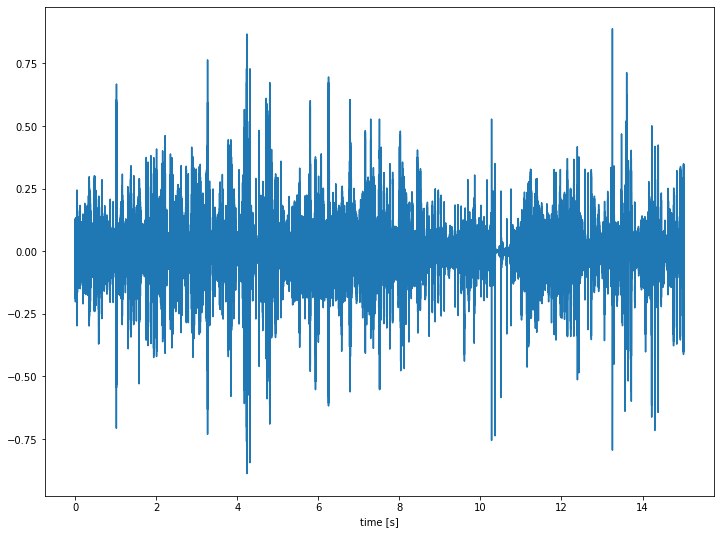

In [11]:
signal_full, sr = librosa.load(audiofile)
print(f'total audio duration of file {audiofile} is : {len(signal_full)/sr:.2f}s')

t = np.linspace(0,len(signal_full)/sr, len(signal_full))
plt.figure(figsize=(12,9))
plt.plot(t, signal_full)
plt.xlabel('time [s]')
plt.plot()

In [12]:
print('FULL DURATION AUDIO CLIP')

Audio(data=signal_full,rate=sr)

FULL DURATION AUDIO CLIP


[]

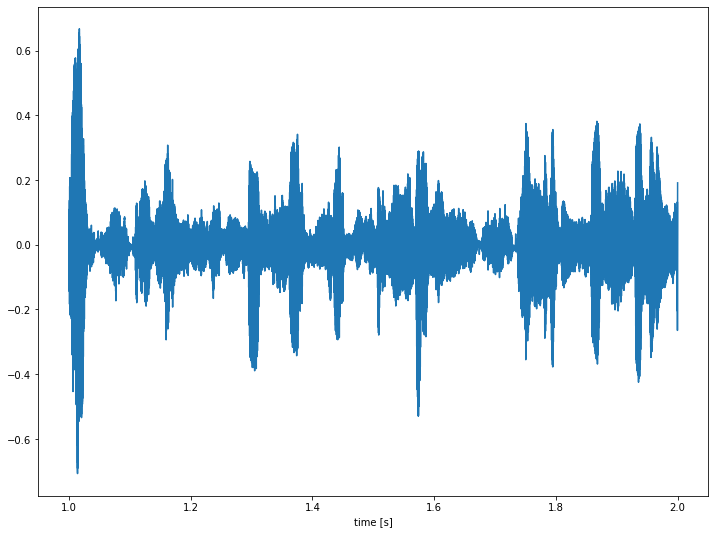

In [17]:
# choose a clip of the full audio file.
# start at 'signal_start' seconds
# and get a clip of duration 'signal_duration' seconds
signal_start = 1
signal_duration = 1

signal = signal_full[signal_start*sr:(signal_start + signal_duration)*sr]

t = np.linspace(signal_start,signal_start+signal_duration, len(signal))
plt.figure(figsize=(12,9))
plt.plot(t, signal)
plt.xlabel('time [s]')
plt.plot()

In [18]:
print('SELECTED PART OF AUDIO CLIP')

Audio(data=signal,rate=sr)

SELECTED PART OF AUDIO CLIP


## 1.4 Modulation Spectrogram of original signal

Plot the modulation spectrograms of the full or clipped audio file

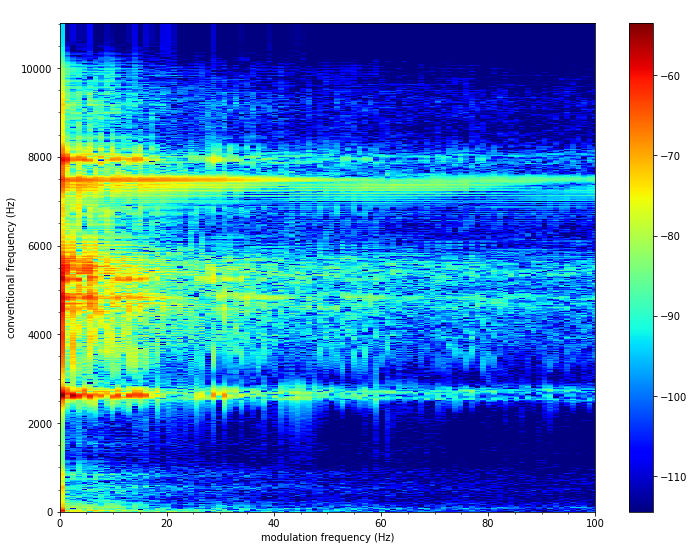

In [19]:

window_size = 1024
window_shift = 16

#choose signal_full or signal as input
ama_input = signal

rfft_mod = ama.strfft_modulation_spectrogram(ama_input,
                                             sr,
                                             window_size,
                                             window_shift,
                                             channel_names=' ',
                                             win_function_y='boxcar',
                                             win_function_x='boxcar')


plt.figure(figsize=(12,9))
ama.plot_modulation_spectrogram_data(rfft_mod, c_map='jet')#,modf_range=[1,40])
plt.xlim([0,100])
plt.show()

# 2 **Modulation filtering** *(remove AE frequencies)*




---


Here is the modulation filtering part.

The process followed in the following sections is the following:

1) The original signal is split in frequency bands

2) For each of the frequency bands, calculate the amplitude envelope (AE)

3) Each AE is passed through a bandstop filter to remove a given range of frequencies

4) Half-wave rectify each AE after the bandstop filtering (that is: if negative amplitudes were introduce during the filtering, set those to zero).

5) The bandstop-filtered AE of each frequency band signal is divided by the AE of the original frequency band signal. Then, the above ratio for each frequency band is multiplied with the original signal of that band

6) a bandstop filter is again applied on all of the band signals resulted from step 5), in order to remove any frequencies outside the range of each bank-filter which might have been introduced during the earlier modulation filtering in step 3).

7) Add all bands together to get the modulation filter (or modified) signal.

---

8) Some modulation spectrograms and audios are created at the end to compare original and final product.

## 2.1 Filter bank original signal

create frequency bands for the filter bank

In [20]:
# start with frequency of 10Hz and creating intervals of an octave each
freqs = [10]

for i in range(1,11):
  freqs.append(freqs[i-1]*2)

print('the frequency intervals are:',freqs)

the frequency intervals are: [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]


apply bandpass filter and plot results

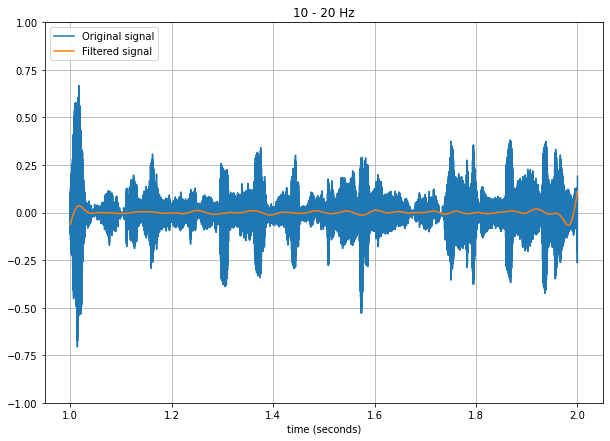

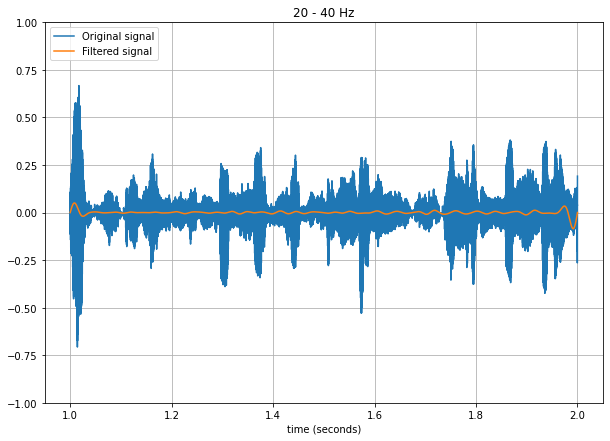

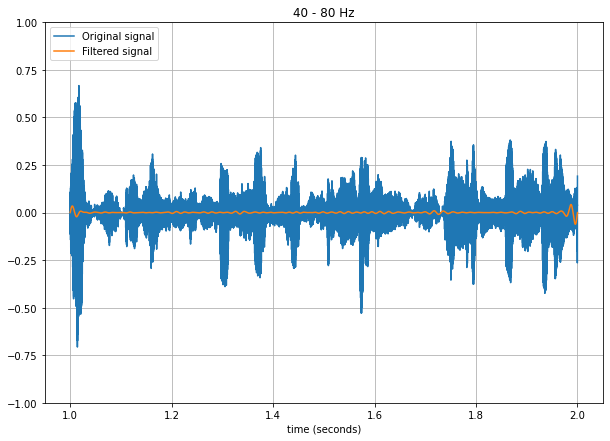

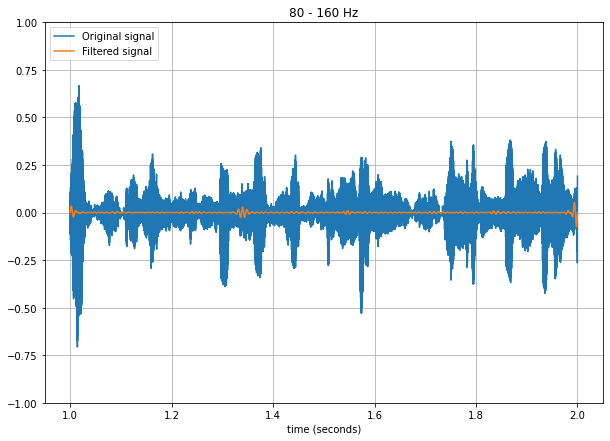

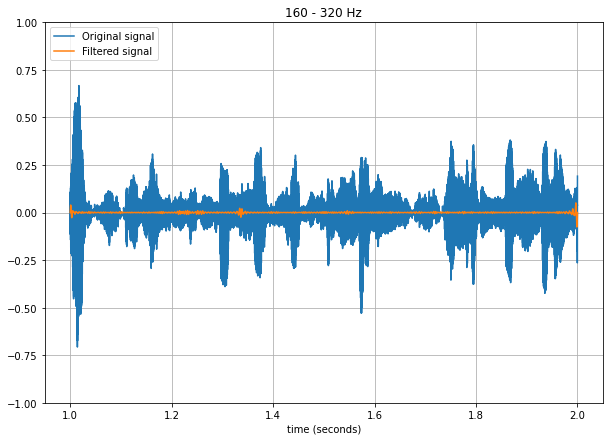

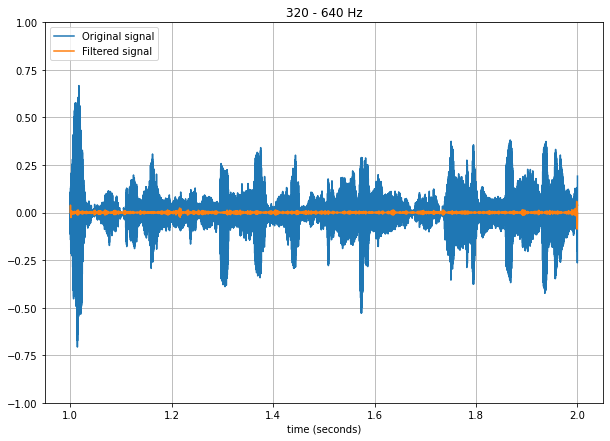

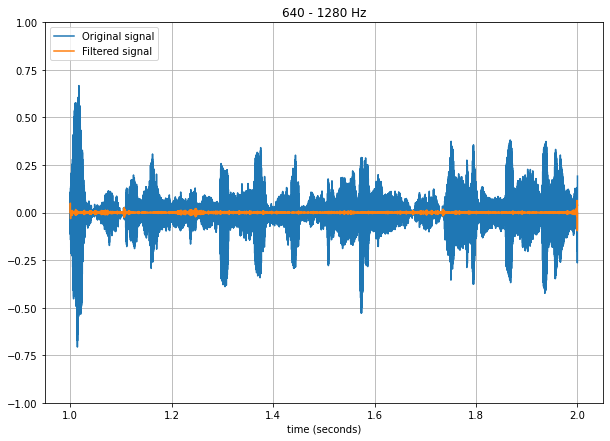

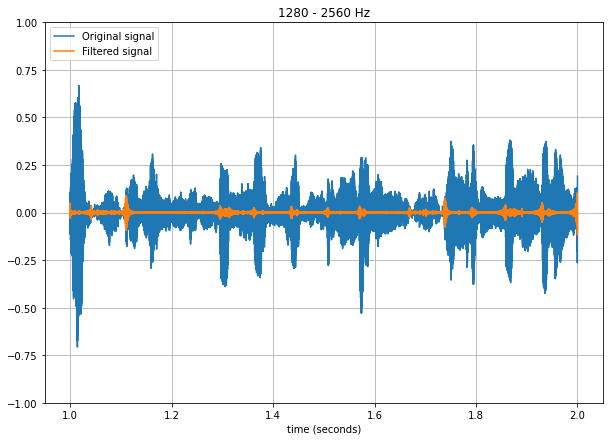

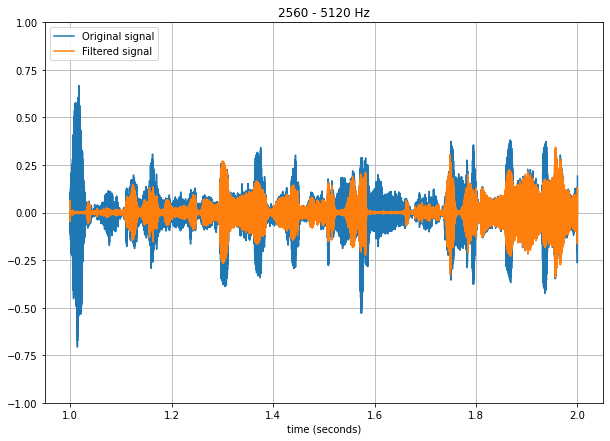

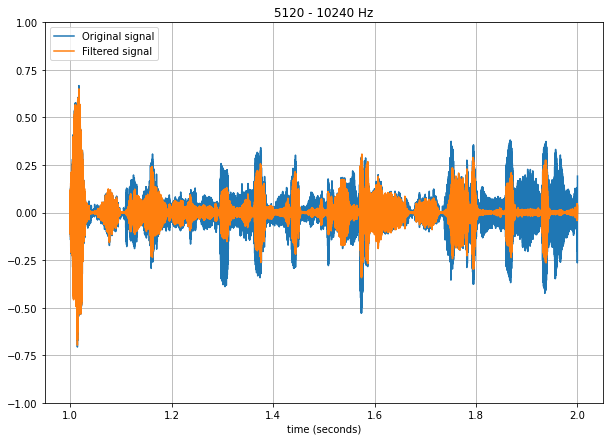

In [21]:
# timepoints for the plots
t = np.linspace(signal_start, signal_start + signal_duration, len(signal), endpoint=False)


bp_signal = []
for i in range(len(freqs)-1):
  lowcut = freqs[i]
  highcut = freqs[i+1]

  #bp_signal.append(butter_bandpass_filter(signal, lowcut, highcut, sr, order=6))
  bp_signal.append(bandpass(signal, sr, lowcut, highcut, bandwidth=50))

  plt.figure(figsize=(10,7))
  plt.clf()
  plt.plot(t, signal, label='Original signal')
  plt.plot(t, bp_signal[i], label='Filtered signal' )
  plt.xlabel('time (seconds)')
  plt.grid(True)
  plt.axis('tight')
  plt.ylim([-1,1])
  plt.legend(loc='upper left')
  plt.title(str(lowcut)+' - '+str(highcut)+' Hz')
  plt.show()


## 2.2 Get Amplitude Envelopes

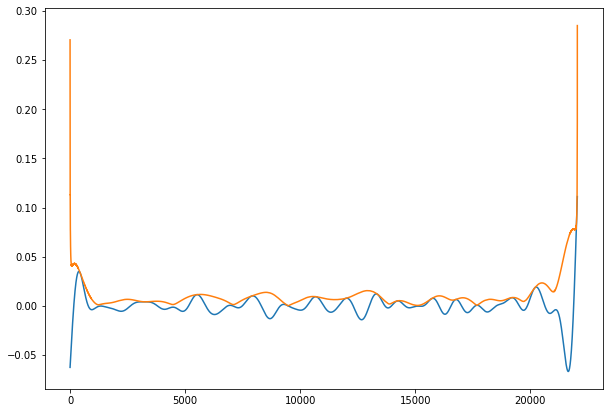

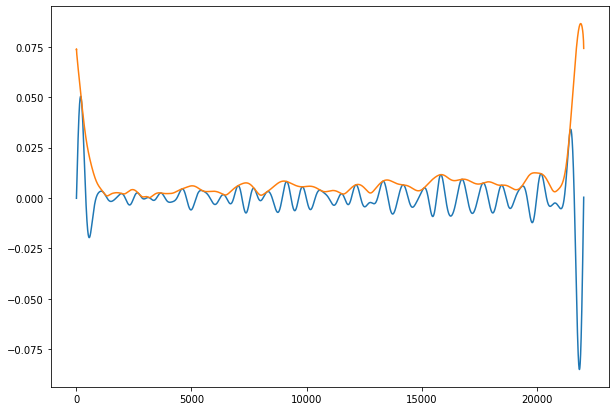

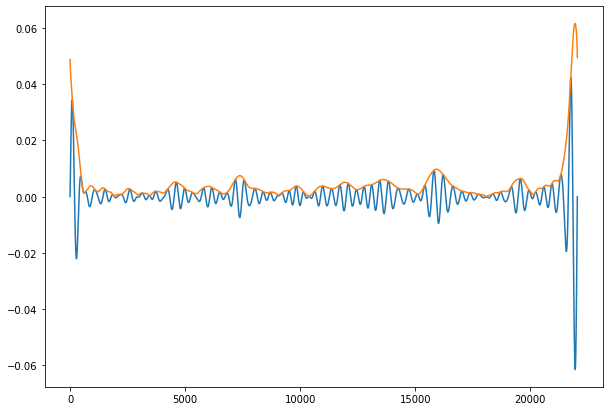

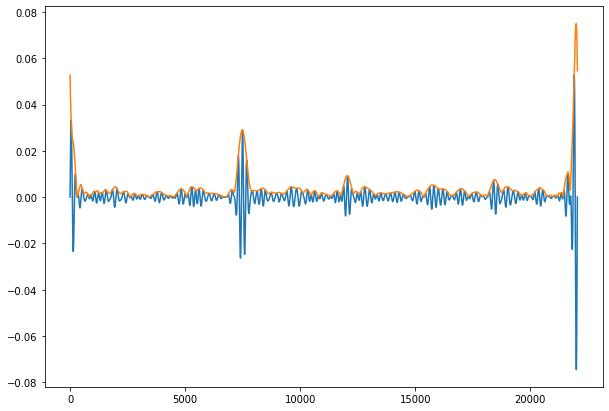

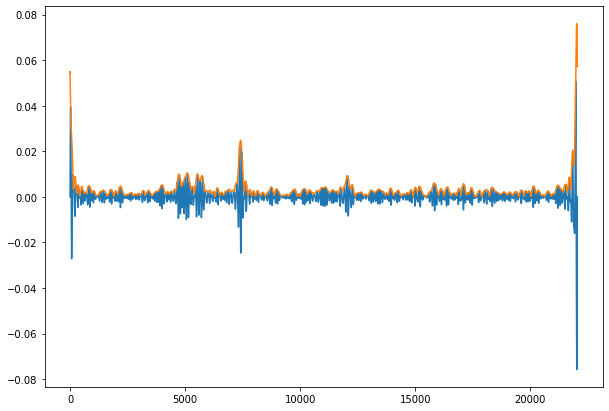

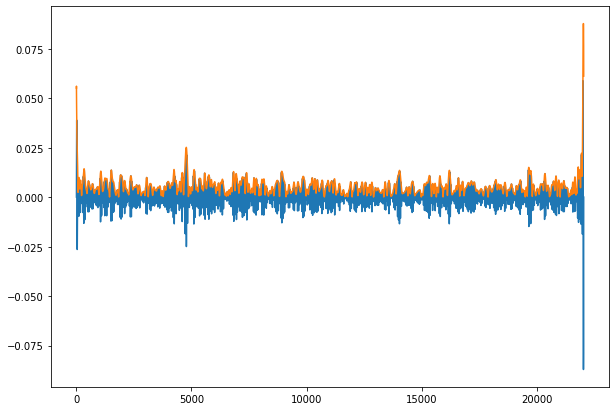

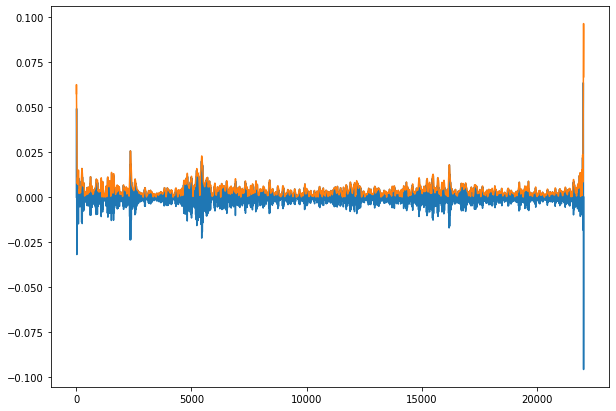

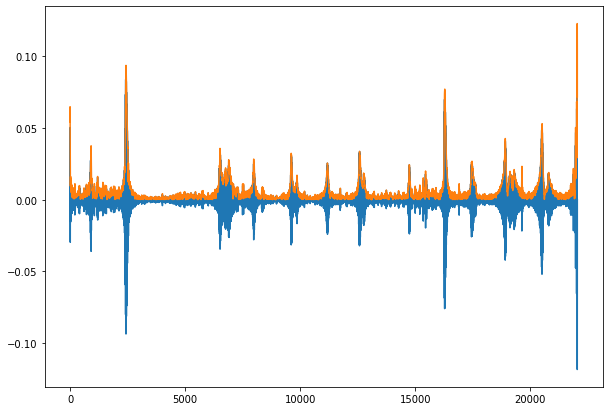

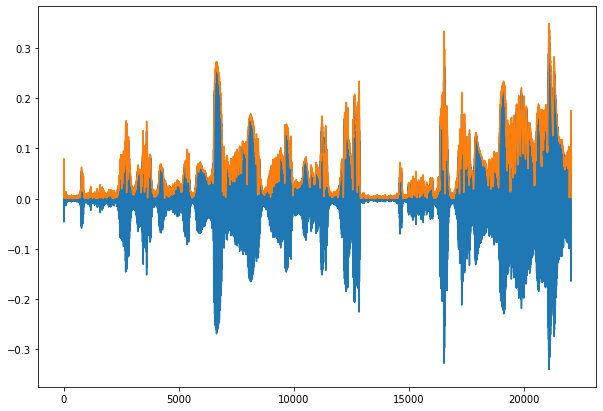

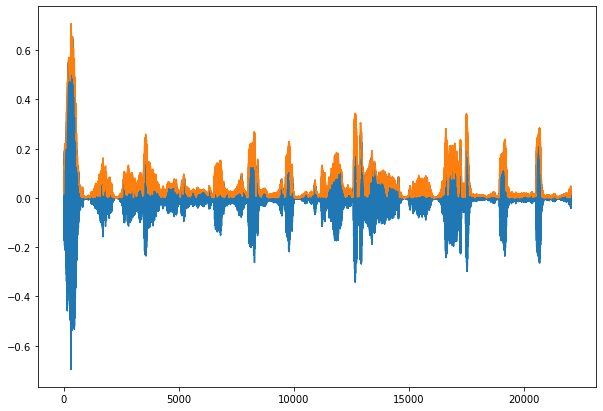

In [106]:
# get the signal A.E. using hilbert transform
amp_env = []
inst_phase = []
for s in bp_signal:
  z = (hilbert(s)) #form the analytical signal
  amp_env.append(np.abs(z)) #envelope extraction
  inst_phase.append(np.unwrap(np.angle(z)))#inst phase
  inst_freq = np.diff(inst_phase)/(2*np.pi)*sr #inst frequency

  plt.figure(figsize=(10,7))
  plt.plot(s)
  plt.plot(amp_env[-1])
  #plt.ylim([-0.5,0.5])
  plt.show()

## 2.3 Bandstop AE using Butterworth bandstop filter

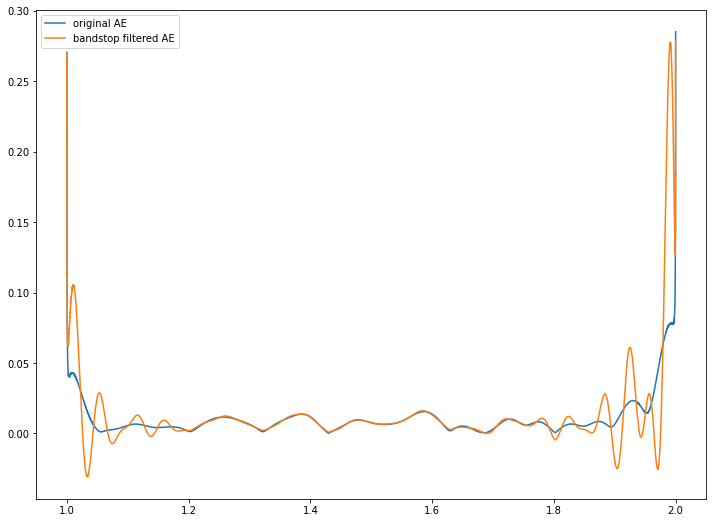

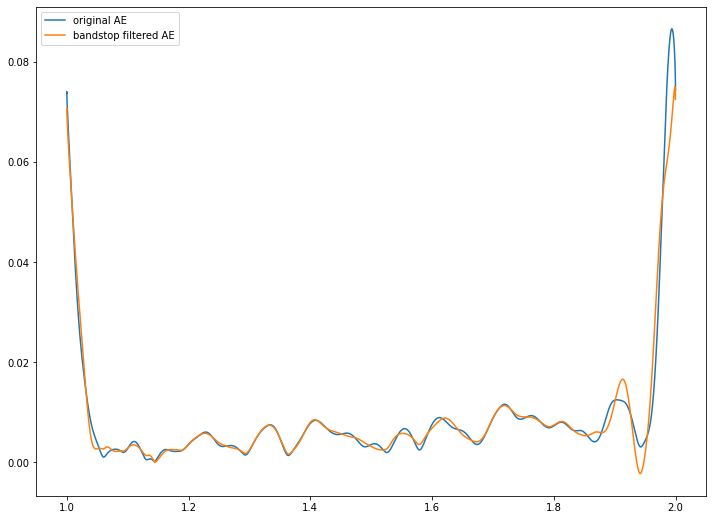

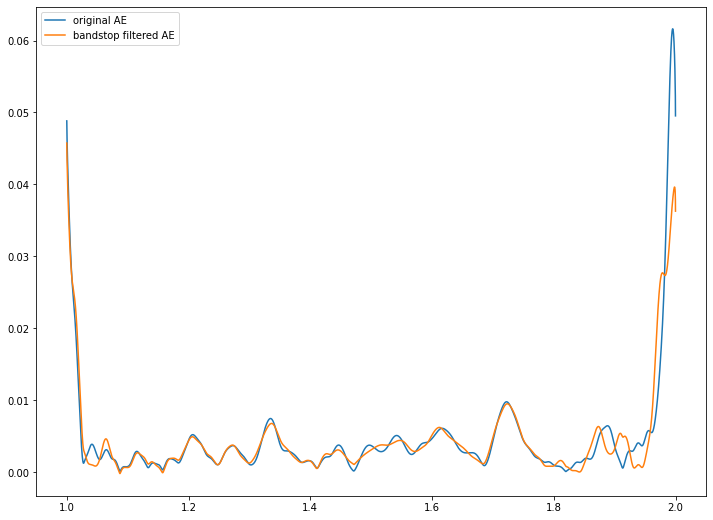

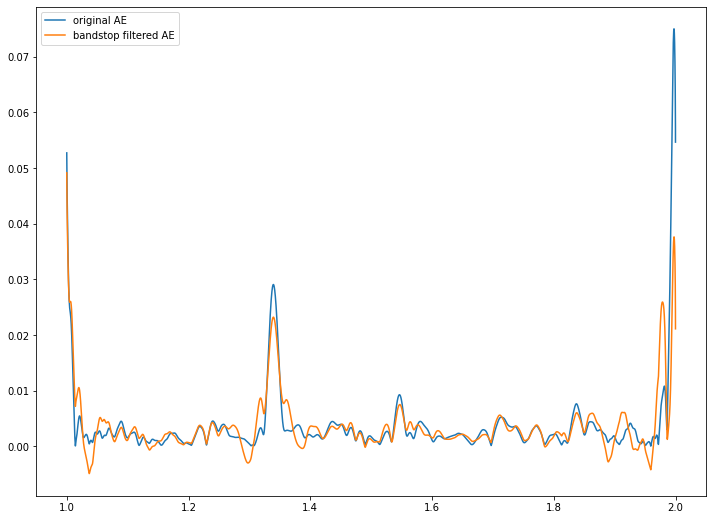

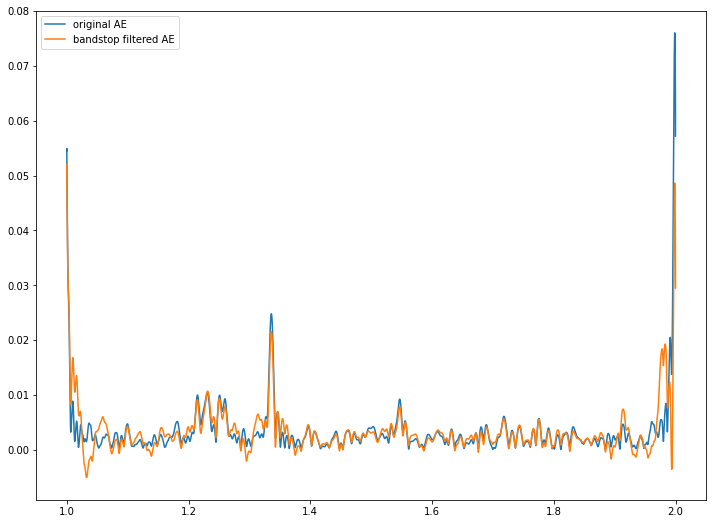

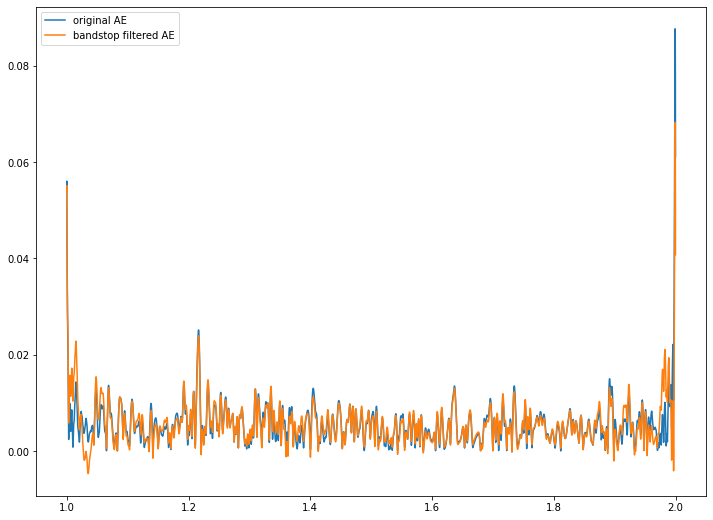

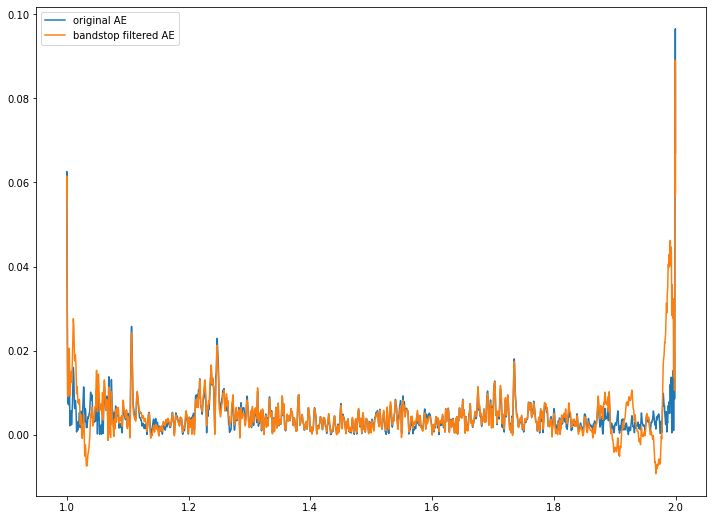

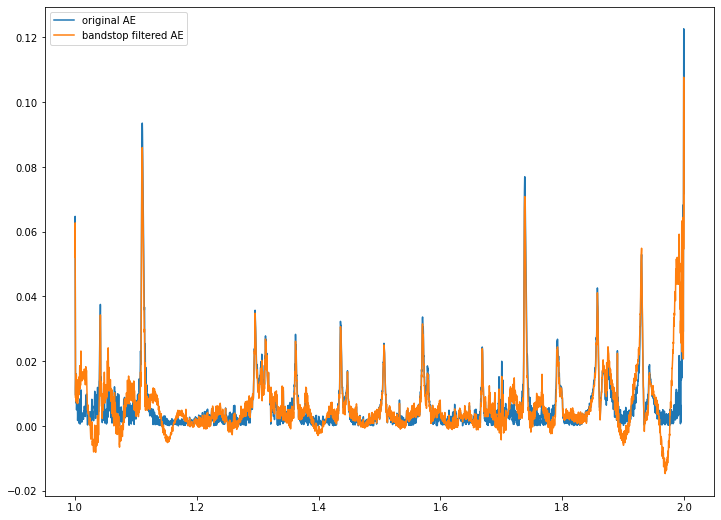

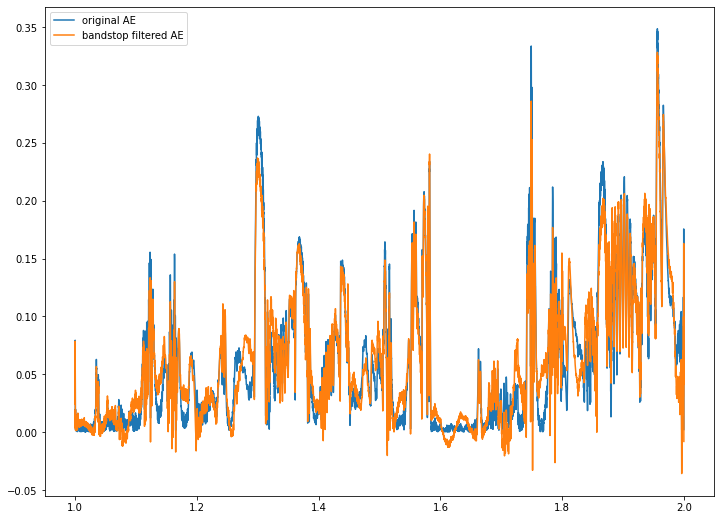

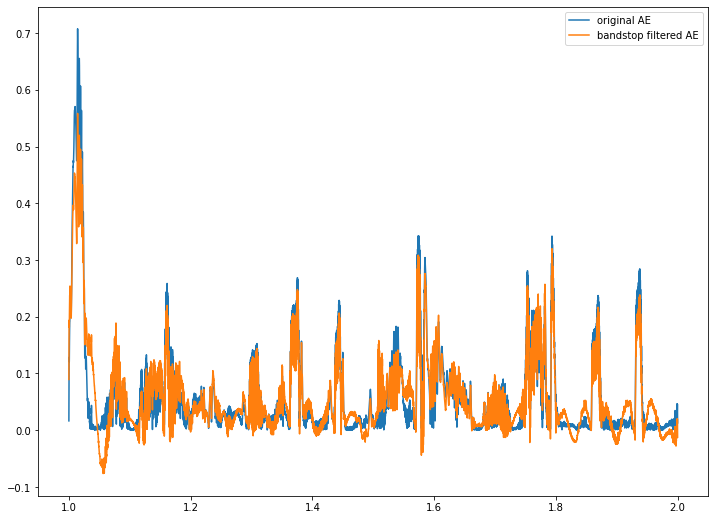

In [107]:

# cut-off frequency (upper bound)
low_f = 20
high_f = 30
order = 3

amp_env_filtered=[]
for ae in amp_env:
  amp_env_filtered.append(butter_bandstop_filter(ae, low_f, high_f, sr, order))
  plt.figure(figsize=(12,9))
  plt.plot(t,ae,label='original AE')
  plt.plot(t,amp_env_filtered[-1],label='bandstop filtered AE')
  plt.legend()
  plt.show()

## 2.4 Half wave rectification


filtering of the AE might introduce negative amplitudes. Perform a half-wave rectification, by setting to sero all negative values.

In [108]:
# define a function that does half-wave rectification
def half_rectify(signal):
  '''
  Half rectifies a signal: set all negative values to zero
  input: a signal in the form of a list/array
  output: rectified signal list
  '''

  signal = list(map(lambda x: 0 if x < 0 else x, signal))  

  return signal

In [109]:
# apply rectification in all filtered envelopes 
amp_env_filtered_rect = []

for envelope in amp_env_filtered:
  amp_env_filtered_rect.append(half_rectify(envelope))

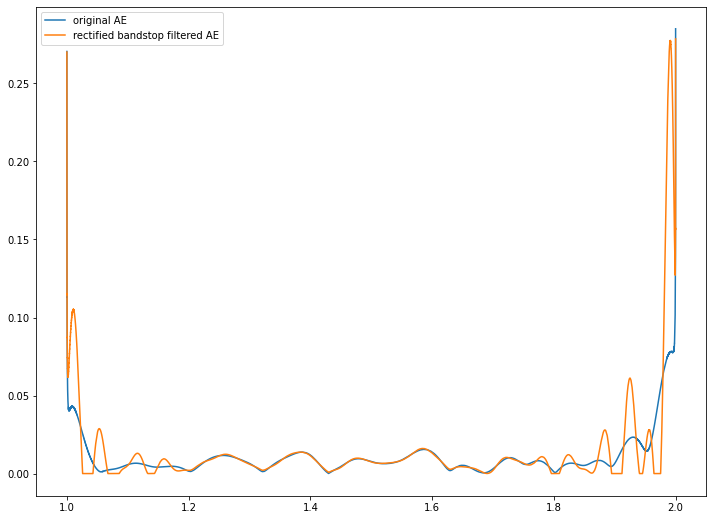

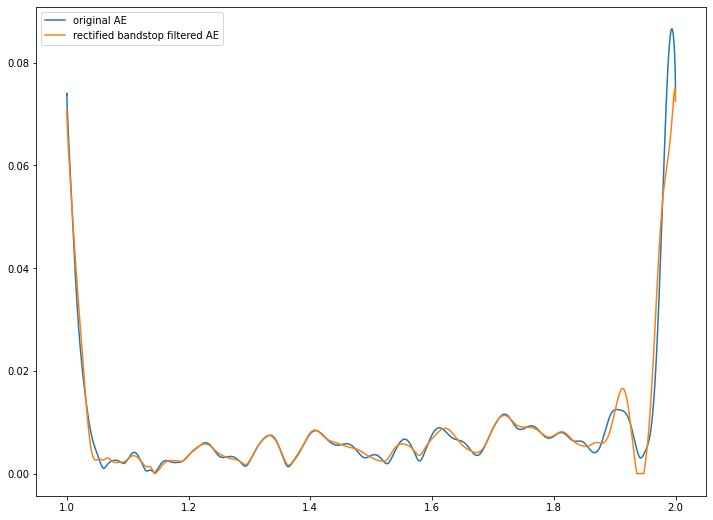

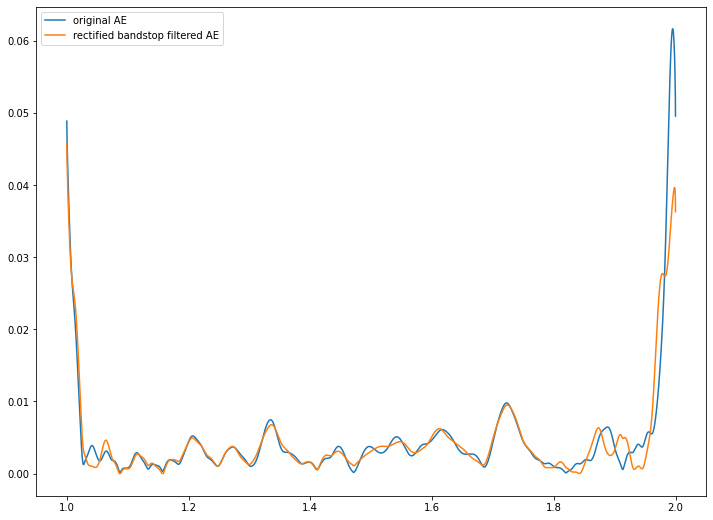

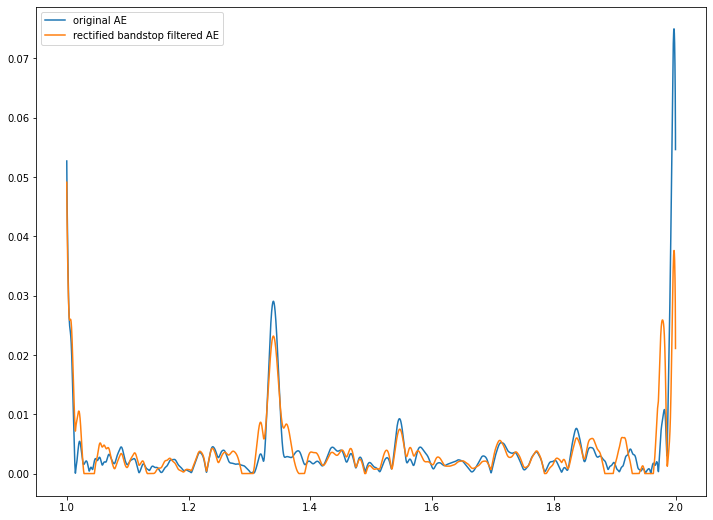

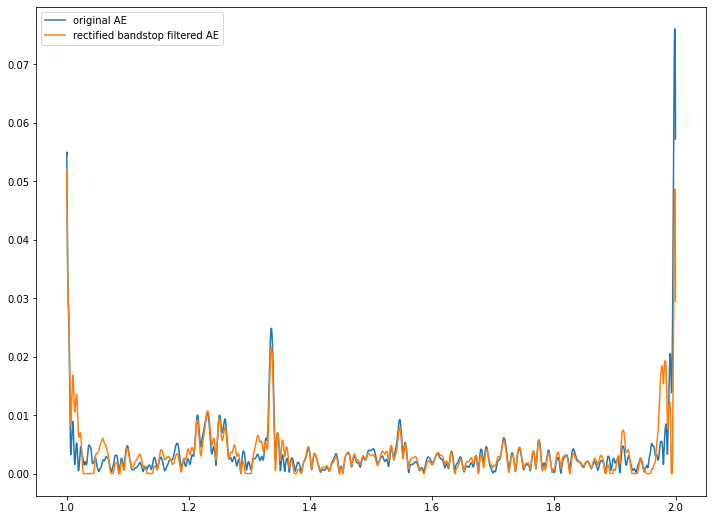

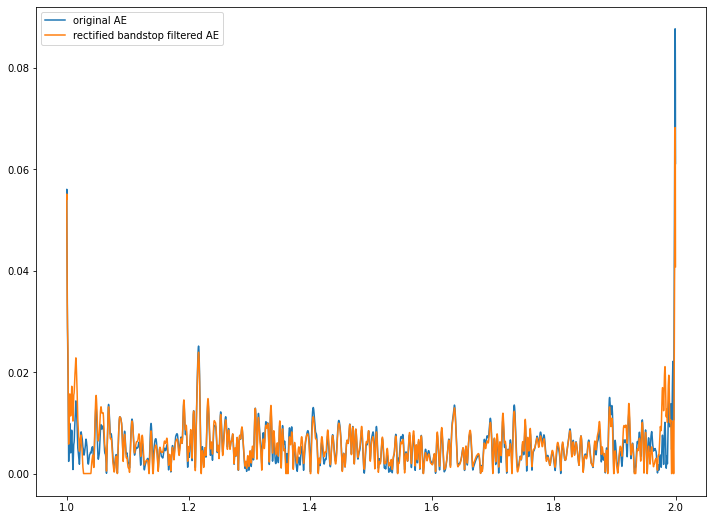

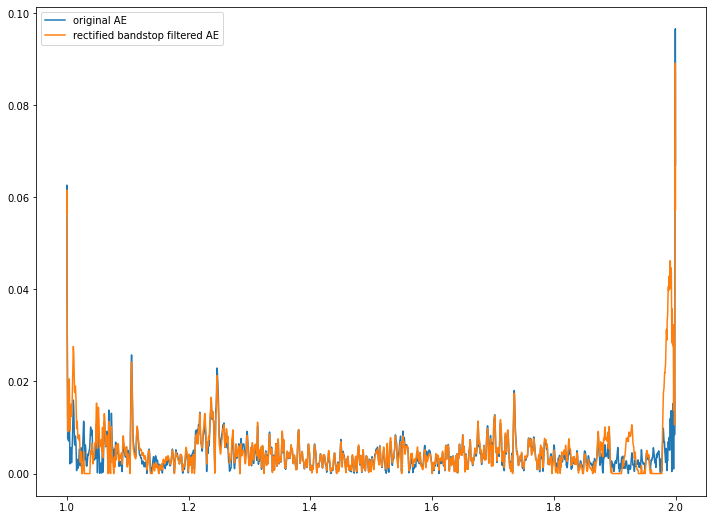

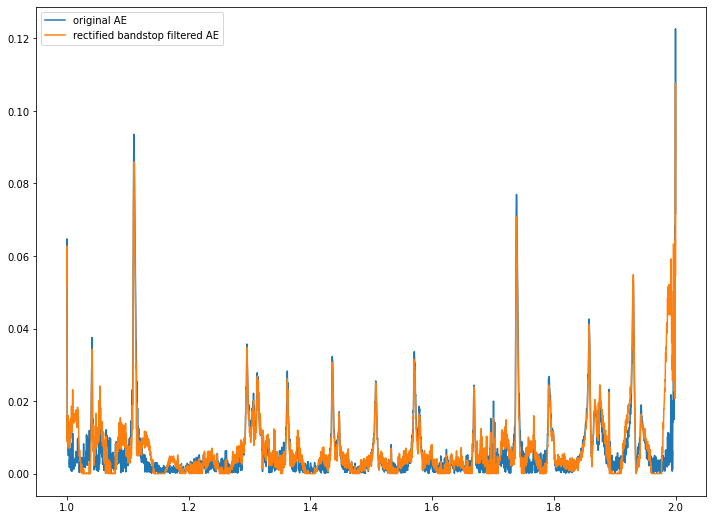

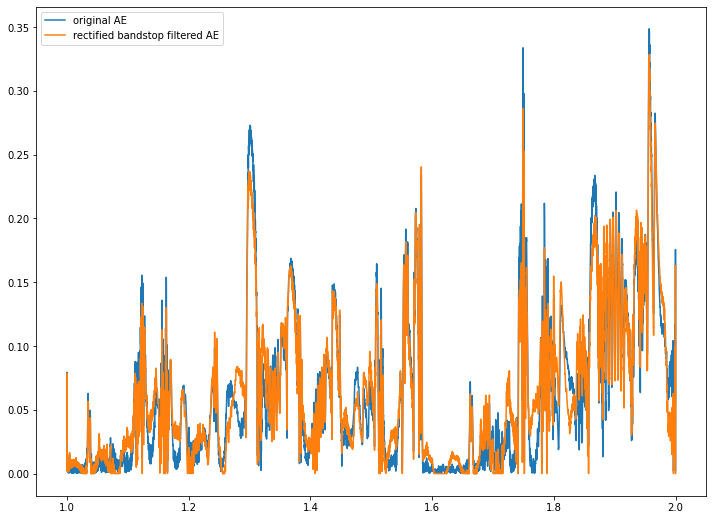

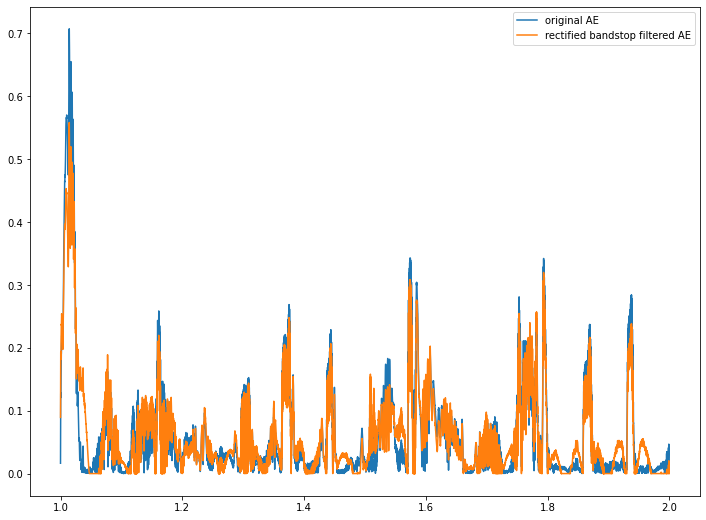

In [110]:
# check how the rectified AE look compared to original full band-signals

for i in range(len(amp_env_filtered_rect)):
  plt.figure(figsize=(12,9))
  plt.plot(t,amp_env[i],label='original AE')
  plt.plot(t,amp_env_filtered_rect[i],label='rectified bandstop filtered AE')
  plt.legend()
  plt.show()

## Modify original BP signal with new envelope

In [111]:
envR  = [i / j for i, j in zip(amp_env_filtered_rect , amp_env)] # calculate the ratio
filt_bp_signal = [ i * j for i,j in zip(bp_signal, envR)] # multiply original audio with ratio


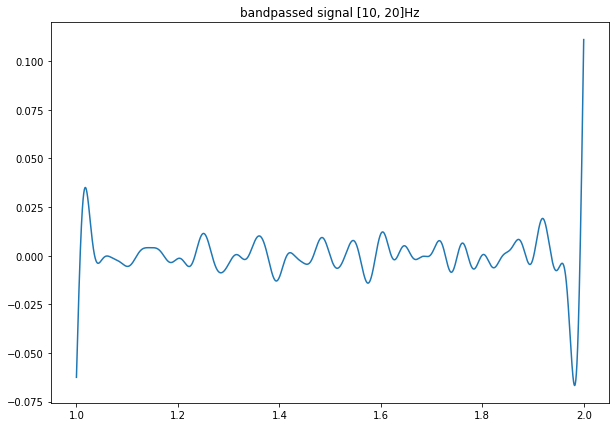

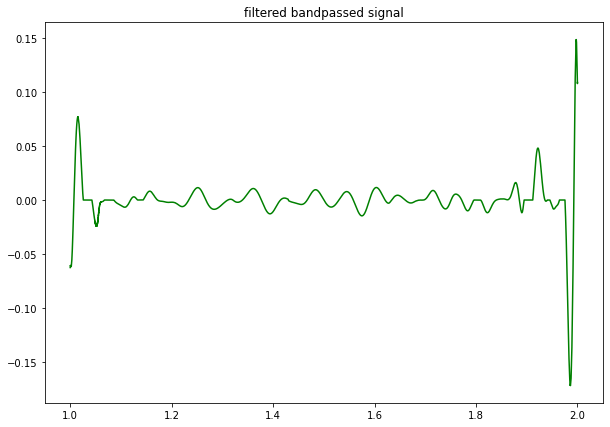

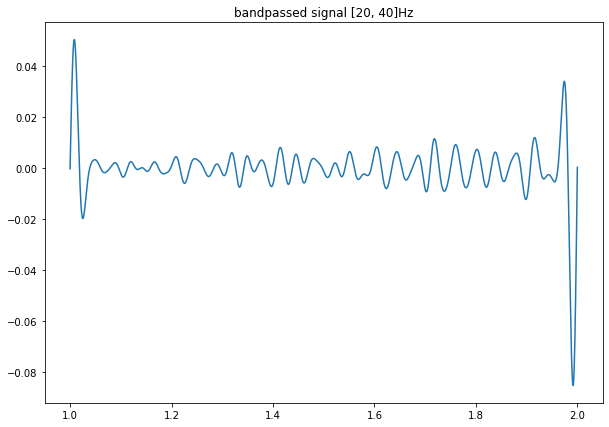

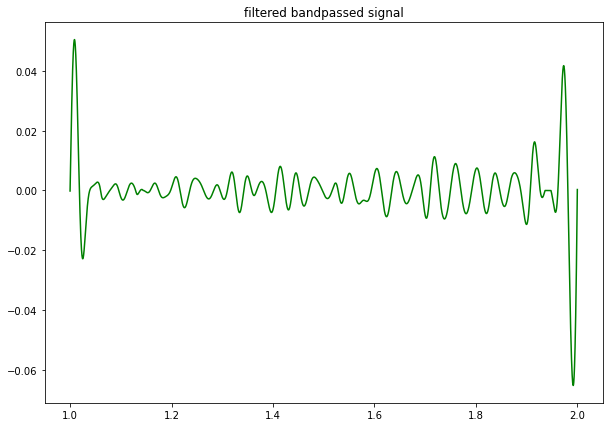

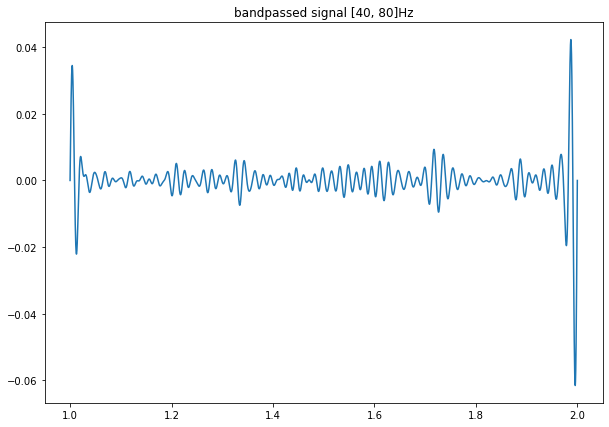

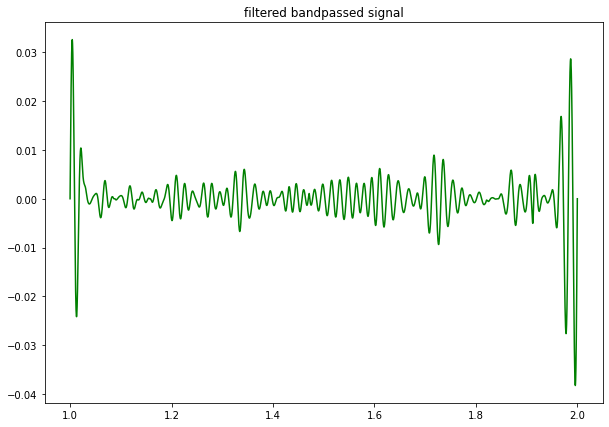

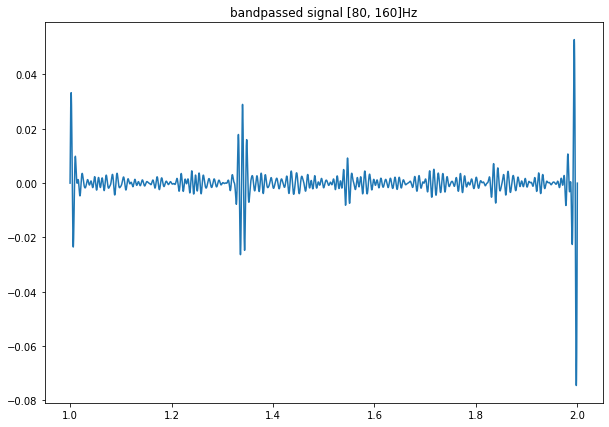

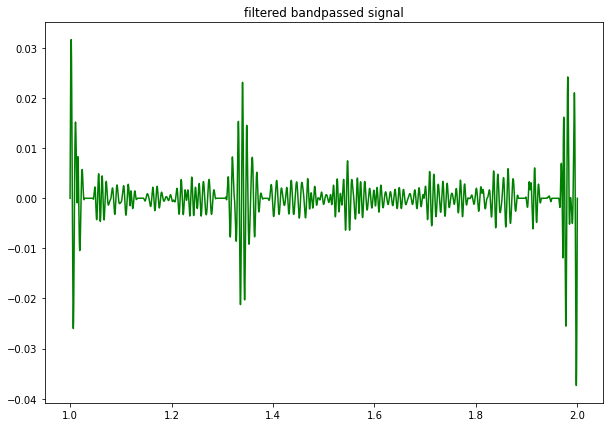

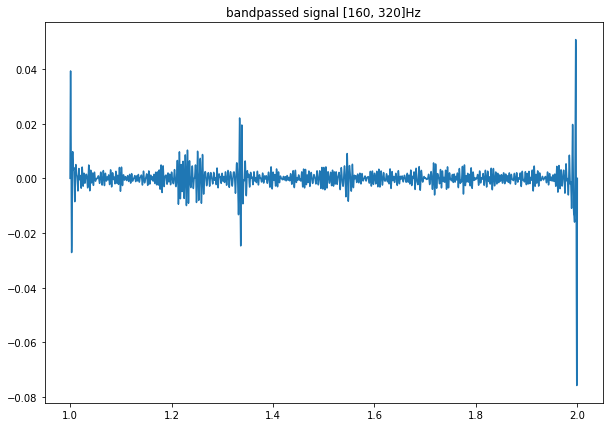

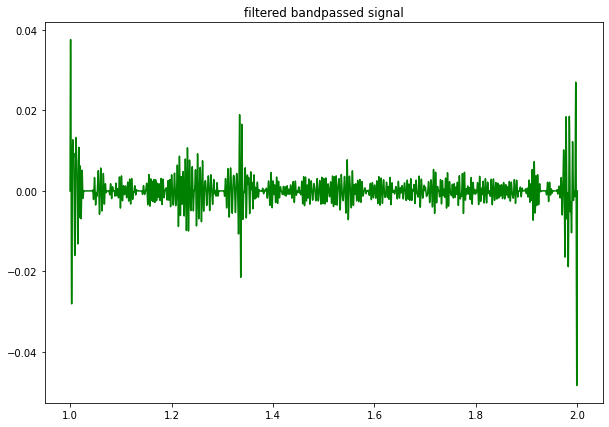

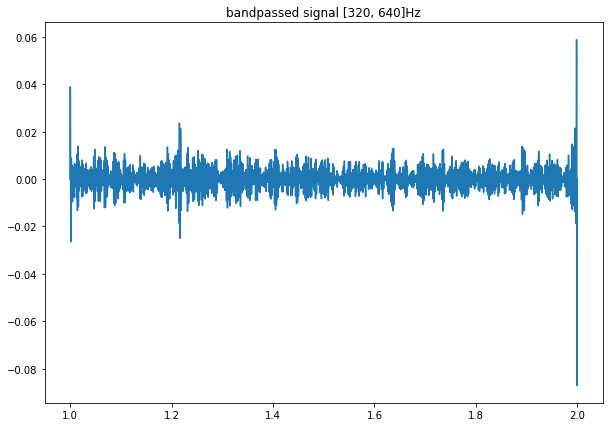

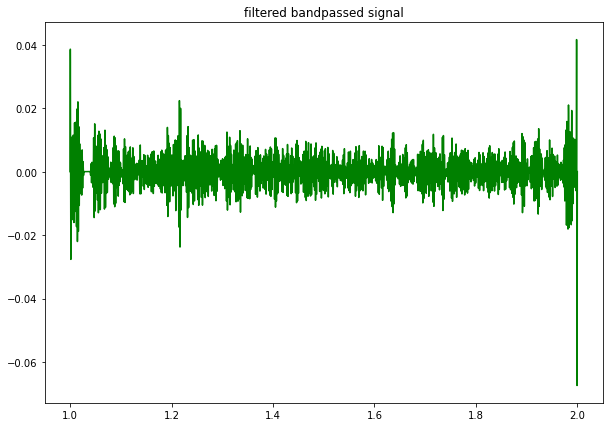

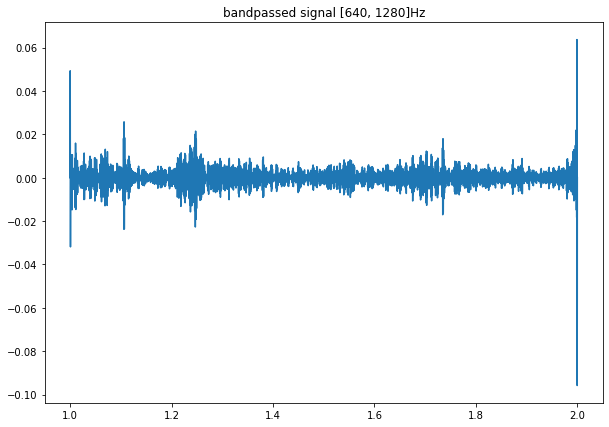

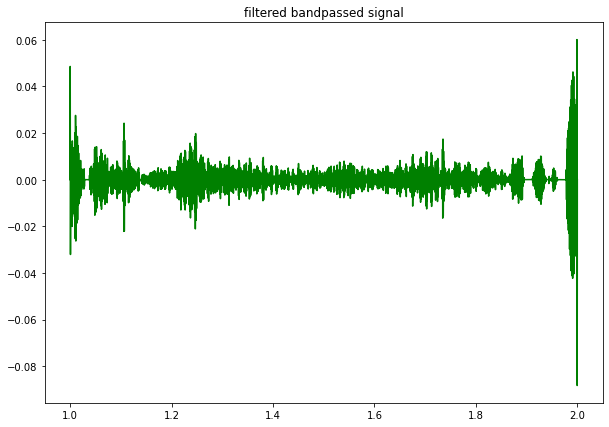

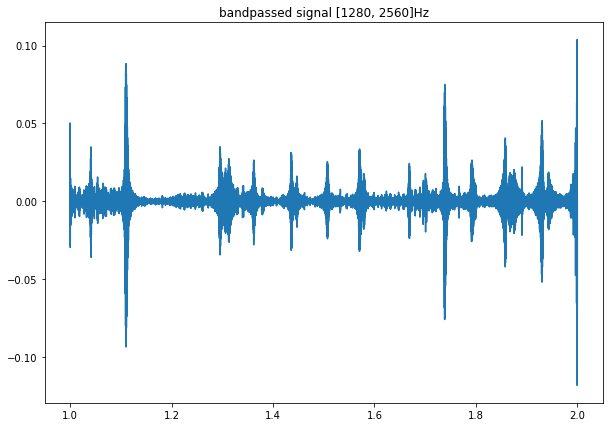

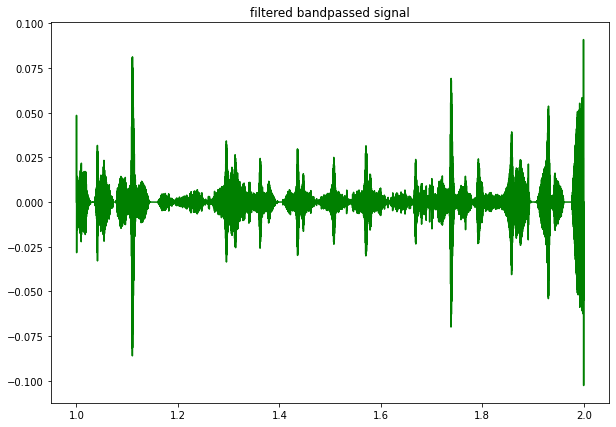

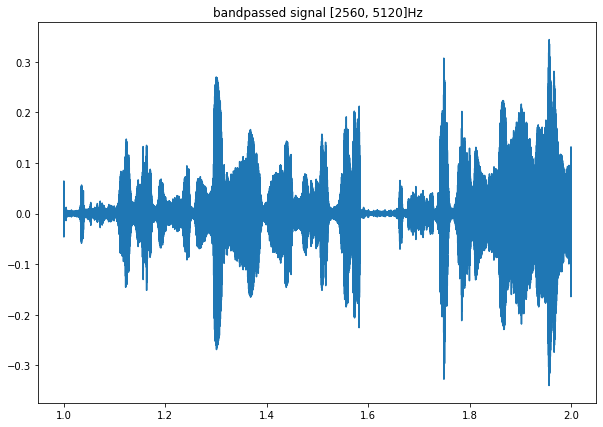

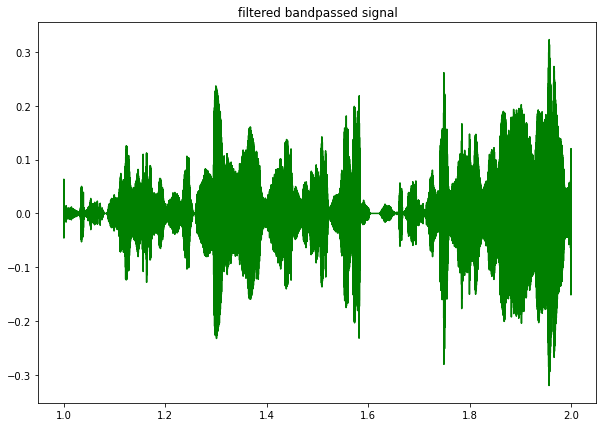

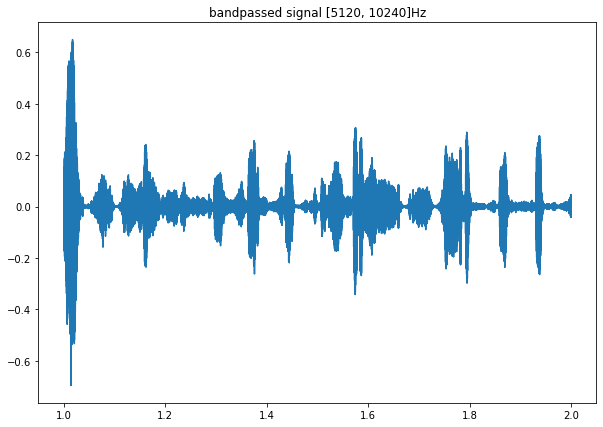

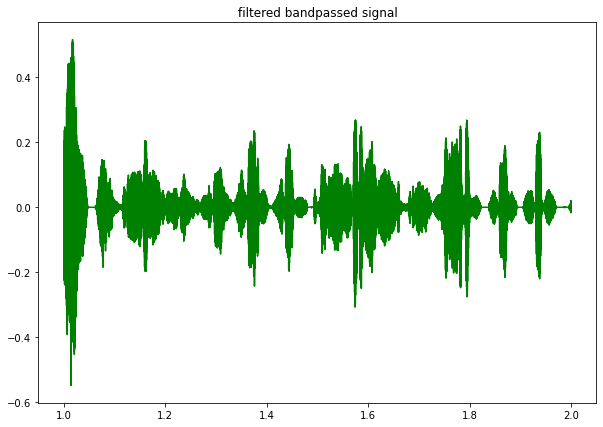

In [112]:

for i in range(len(filt_bp_signal)):
  
  plt.figure(figsize=(10,7))
  plt.figure(1)
  plt.title(f'bandpassed signal {[freqs[i] , freqs[i+1]]}Hz')
  plt.plot(t,bp_signal[i])
  plt.figure(figsize=(10,7))
  plt.figure(2)
  plt.title('filtered bandpassed signal')
  plt.plot(t,filt_bp_signal[i],c='g')
  plt.show()


## 2.6 Bandpass modified band signals

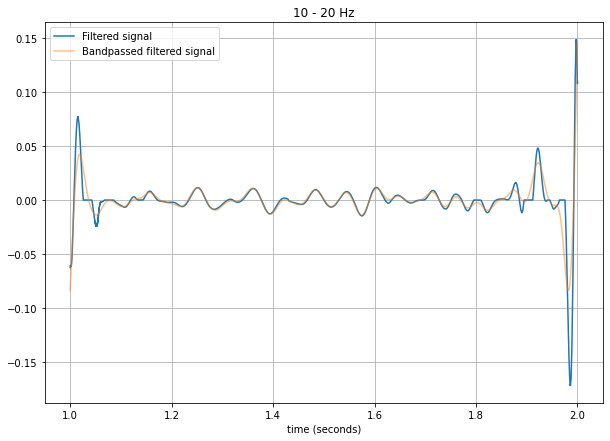

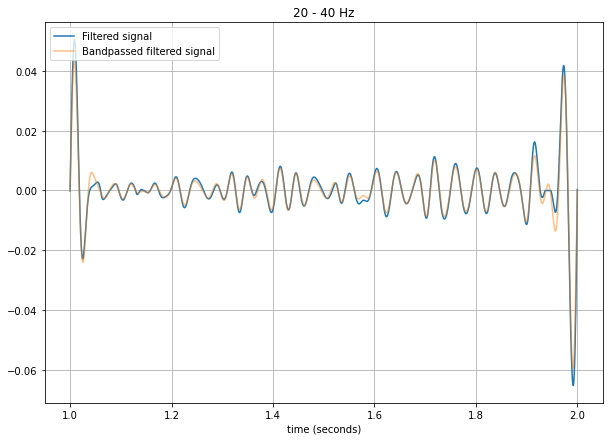

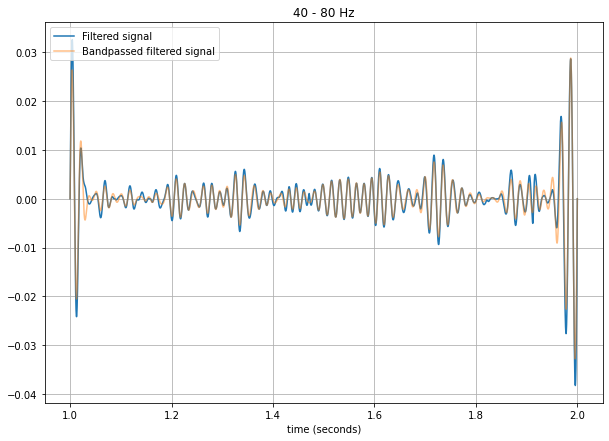

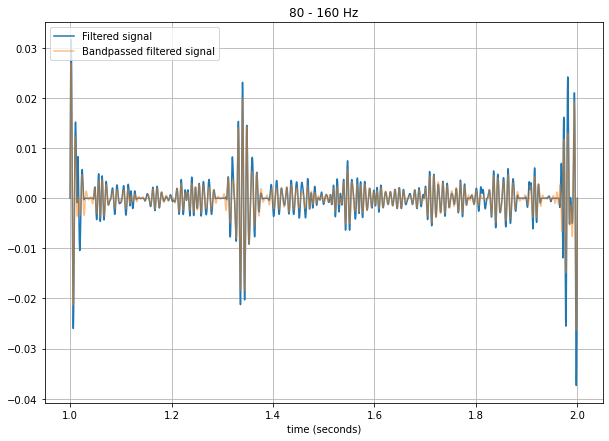

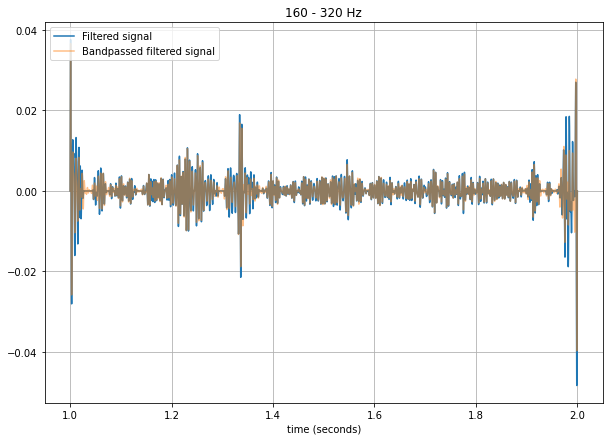

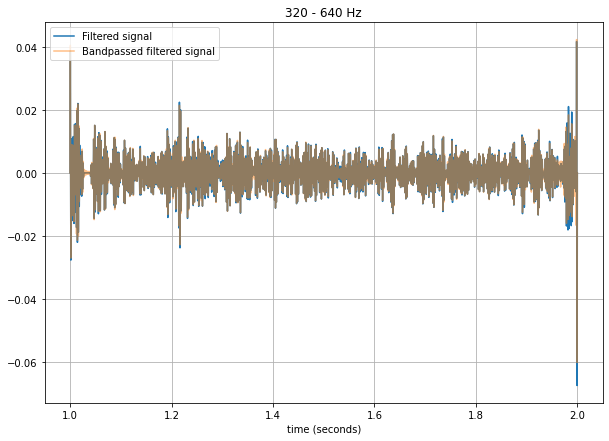

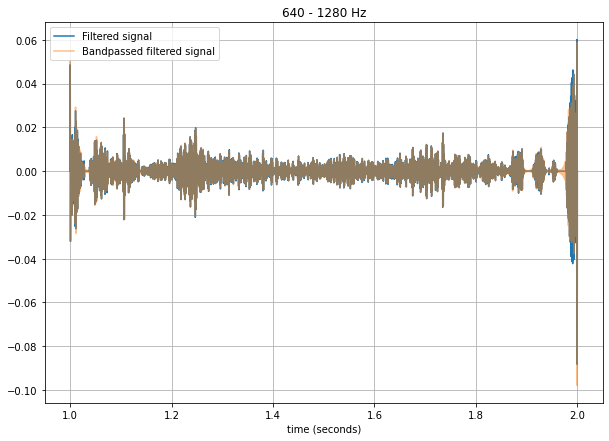

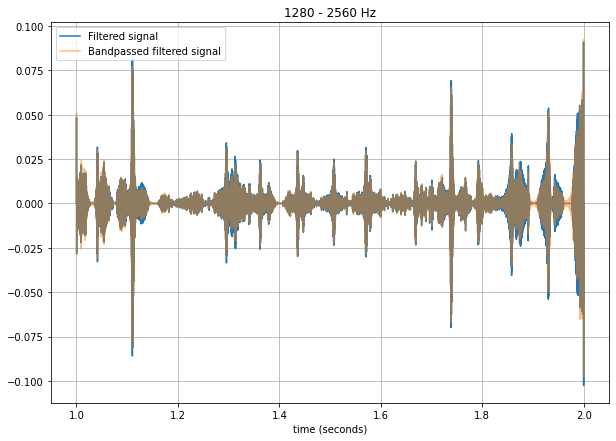

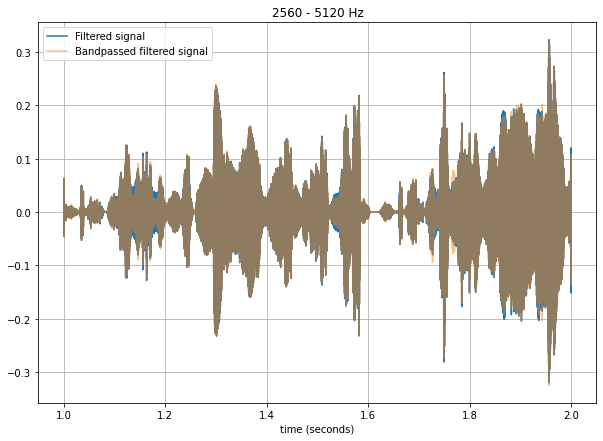

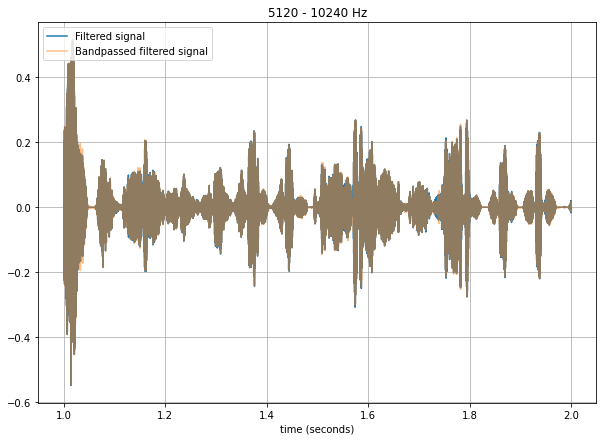

In [113]:
bp_filt_bp_signal = []

for i in range(len(freqs)-1):
  lowcut = freqs[i]
  highcut = freqs[i+1]

  bp_filt_bp_signal.append(bandpass(filt_bp_signal[i], sr, lowcut, highcut, bandwidth=80))

  plt.figure(figsize=(10,7))
  plt.clf()
  plt.plot(t, filt_bp_signal[i], label='Filtered signal')
  plt.plot(t, bp_filt_bp_signal[i], label='Bandpassed filtered signal',alpha=0.5)
  plt.xlabel('time (seconds)')
  plt.grid(True)
  plt.axis('tight')
  #plt.ylim([-1,1])
  plt.legend(loc='upper left')
  plt.title(str(lowcut)+' - '+str(highcut)+' Hz')
  plt.show()


## 2.7 Sum all modified bandpass signals

In [114]:
mod_signal=sum(bp_filt_bp_signal)

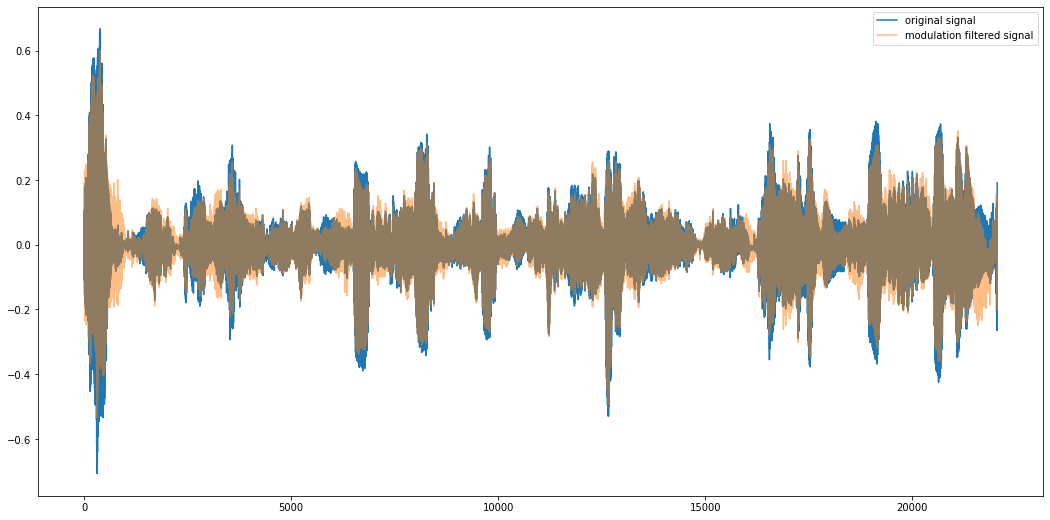

In [117]:
plt.figure(figsize=(18,9))
plt.plot(signal,label='original signal')
plt.plot(mod_signal,alpha=0.5,label='modulation filtered signal')
plt.legend()
plt.show()

## 2.8 Comparisons

### 2.8.1 Compare modulation spectrograms

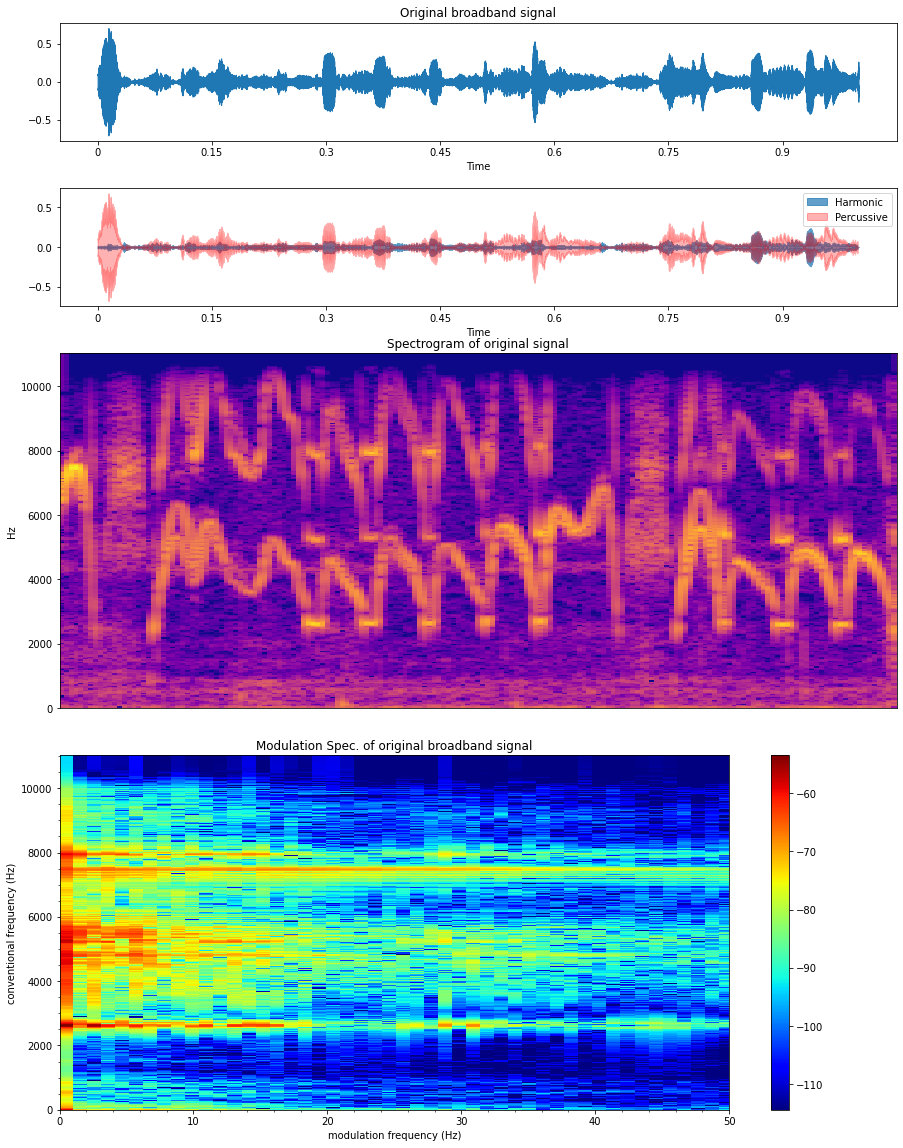

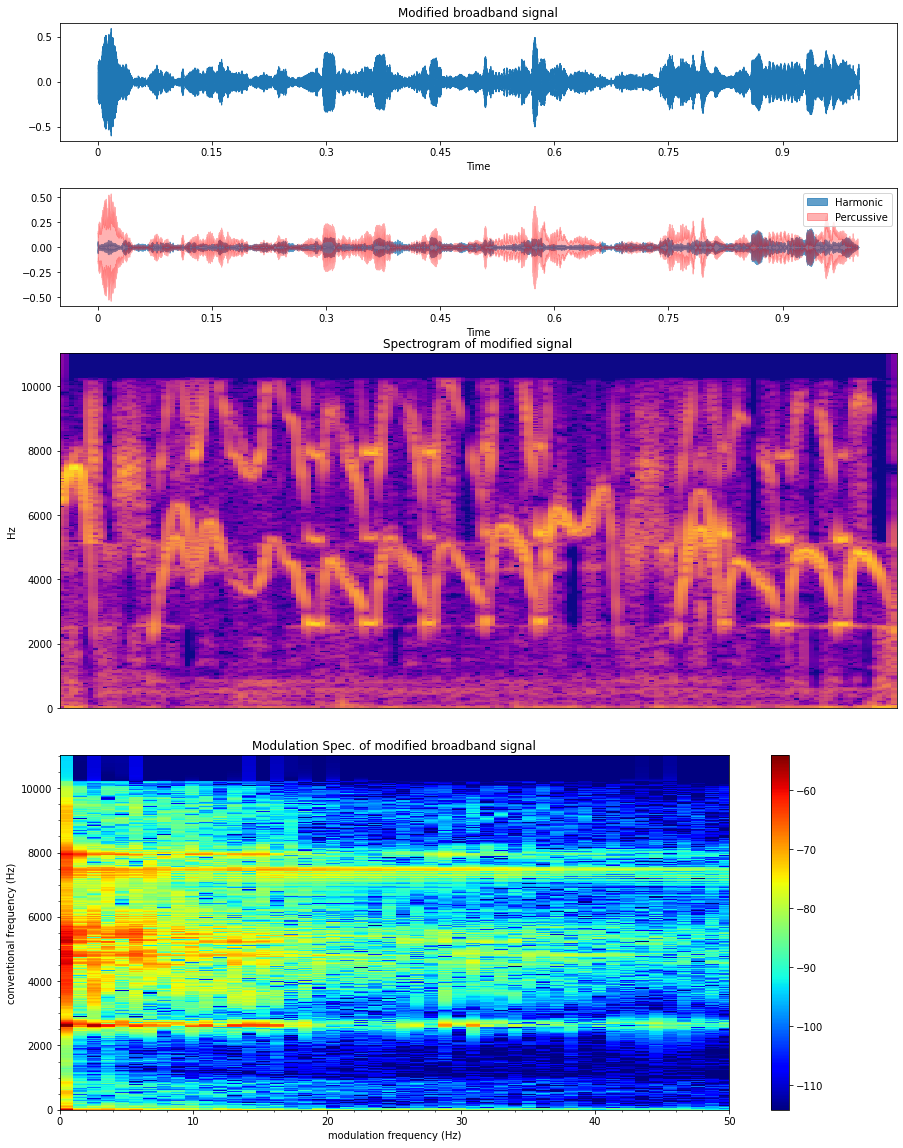

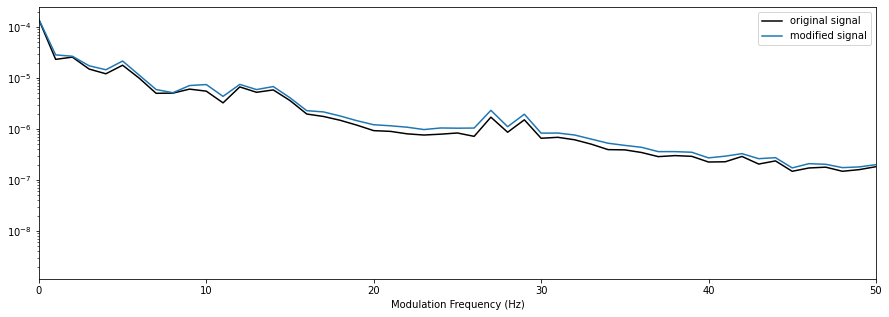

In [118]:
window_size = 1024
window_shift = 16

#Original signal

y_harm, y_perc = librosa.effects.hpss(signal)
stft = librosa.stft(signal,n_fft=512,hop_length=128)

spec_power = np.abs(stft)**2
p_to_db = librosa.power_to_db(spec_power)
modul_spec_orig=np.sum(rfft_mod['power_modulation_spectrogram'],axis=0)

ama_input = signal

rfft_mod = ama.strfft_modulation_spectrogram(ama_input,
                                             sr,
                                             window_size,
                                             window_shift,
                                             channel_names=' ',
                                             win_function_y='boxcar',
                                             win_function_x='boxcar')


fig, ax = plt.subplots(nrows=4, sharex=False,gridspec_kw={'height_ratios': [1, 1,3, 3]},figsize=(15,20))

librosa.display.waveshow(signal, sr=sr, ax=ax[0])
librosa.display.waveshow(y_harm, sr=sr, alpha=0.7,  label='Harmonic',ax=ax[1])
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.3, label='Percussive',ax=ax[1])
librosa.display.specshow(p_to_db, sr=sr,y_axis='linear',ax = ax[2], cmap='plasma')

ama.plot_modulation_spectrogram_data(rfft_mod, c_map='jet')#,modf_range=[1,40])

ax[0].set_title('Original broadband signal')
ax[2].set_title('Spectrogram of original signal')
ax[3].set_title('Modulation Spec. of original broadband signal')
ax[3].set_xlim([0,50])
ax[1].legend()
plt.show()


# Modified signal

y_harm, y_perc = librosa.effects.hpss(mod_signal)
stft = librosa.stft(mod_signal,n_fft=512,hop_length=128)
spec_power = np.abs(stft)**2
p_to_db = librosa.power_to_db(spec_power)
modul_spec_mod=np.sum(rfft_mod['power_modulation_spectrogram'],axis=0)


ama_input = mod_signal

rfft_mod = ama.strfft_modulation_spectrogram(ama_input,
                                             sr,
                                             window_size,
                                             window_shift,
                                             channel_names=' ',
                                             win_function_y='boxcar',
                                             win_function_x='boxcar')


fig, ax = plt.subplots(nrows=4, sharex=False,gridspec_kw={'height_ratios': [1, 1,3, 3]},figsize=(15,20))

librosa.display.waveshow(mod_signal, sr=sr, ax=ax[0])
librosa.display.waveshow(y_harm, sr=sr, alpha=0.7,  label='Harmonic',ax=ax[1])
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.3, label='Percussive',ax=ax[1])
librosa.display.specshow(p_to_db, sr=sr,y_axis='linear',ax = ax[2], cmap='plasma')

ama.plot_modulation_spectrogram_data(rfft_mod, c_map='jet')#,modf_range=[1,40])

ax[0].set_title('Modified broadband signal')
ax[2].set_title('Spectrogram of modified signal')
ax[3].set_title('Modulation Spec. of modified broadband signal')
ax[1].legend()
ax[3].set_xlim([0,50])
plt.show()



print('\n')
print('\n')
print('\n')

plt.figure(figsize=(15,5))
plt.plot(modul_spec_orig,c='k',label='original signal')
plt.plot(modul_spec_mod,label = 'modified signal')
plt.yscale('log')
plt.xlabel('Modulation Frequency (Hz)')
plt.xlim([0,50])
plt.legend()
plt.show()

### 2.8.2 Compare audio before and after

In [119]:
print('ORIGINAL AUDIO CLIP')

Audio(data=signal,rate=sr)



ORIGINAL AUDIO CLIP


In [120]:
print('MODIFIED AUDIO CLIP')

Audio(data=mod_signal,rate=sr)

MODIFIED AUDIO CLIP


### 2.8.3 Save modified file as wav file

In [ ]:
# Give a name for the file to be saved
save_name = 'modified.wav'

# write file (if in colab, remember to download it before leaving the session)
sf.write(save_name, mod_signal, sr)

# 3 **Reverse modulation filtering** *(reintroduce removed frequencies)*

These are the steps followed below, in order to restore the frequencies which were removed during the amplitude envelope modulation filtering process above.

1) Get the difference [*sig_removed*] between the bank-filtered AEs of the original signal [*amp_env*] and their modulation-filtered counterparts [*amp_env_filtered*]

2) Calculate the FFT of the difference [*fft_sig_removed*]

3) Bank filter the modified signal [*mod_signal*]. That is, take the final output from the 'Modulation filtering' section above, and separate it into the same frequency bands that the original signal was. Resulting list of arrays is [*bp_mod_signal*]

4) Now find the Amplitute Envelope for each of these frequency bands. Resulting list of arrays is [*mod_amp_env*]

5)Transfer each one of these amplitude envelopes to the frequency domain by applying FFT (resulting list of arrays: [*fft_mod_amp_env*])

6) Add FFT of the difference [*fft_sig_removed*] to the FFT of the modified amplitude envelopes [*fft_mod_amp_env*]. Then apply iFFT to go back to time domain signals [*revovered_amp_env*].

7) Put together the full recovered signal: multiply the ratio of the recovered AE to the modifired AE [*mod_envR*] with the modified signal [*mod_bp_signal*]  (for each frequency band). Then sum up all frequency bands. This gives the final [*recovered_signal*].

8) Finally, take a look and listen to the compared audio

## 3.1 Difference between bank-filtered AE and modulation-filtered bank-filtered AE

<Figure size 720x504 with 0 Axes>

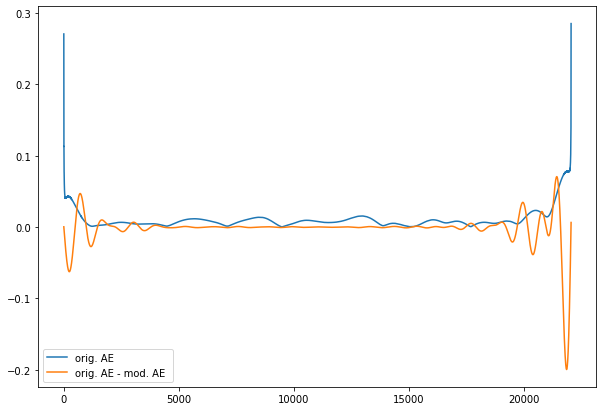

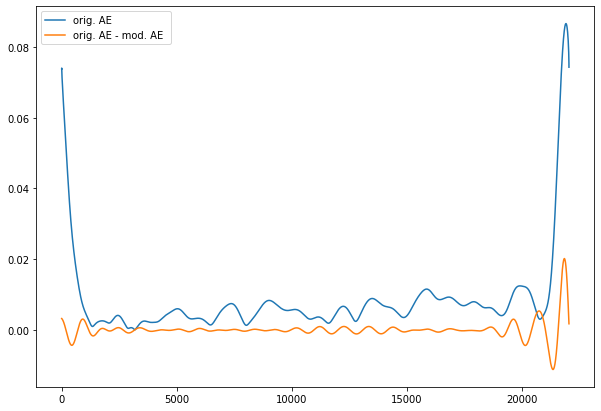

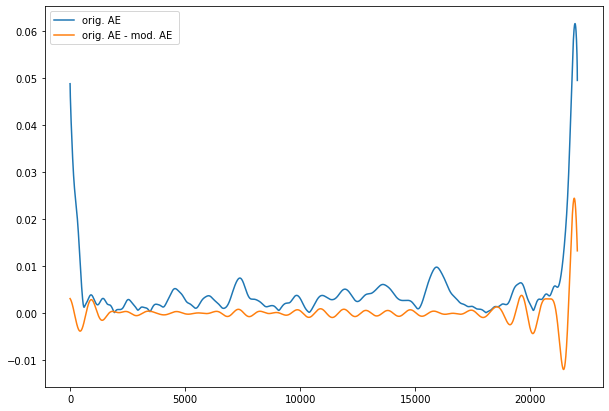

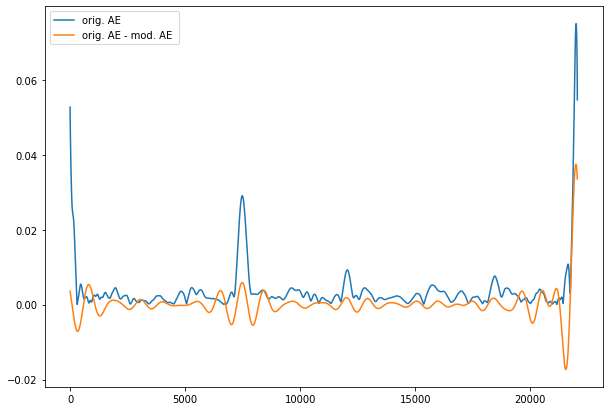

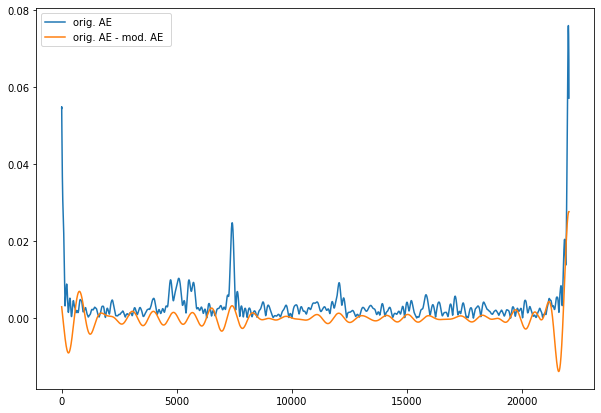

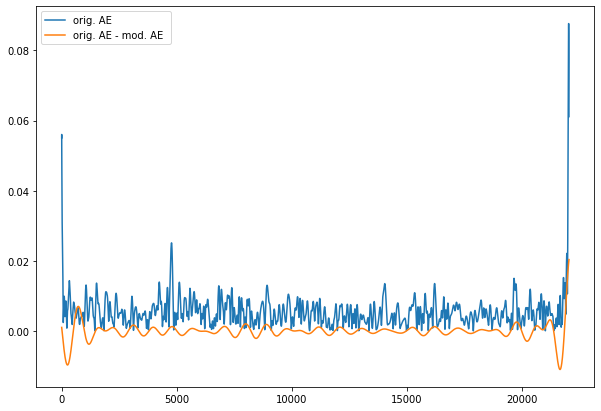

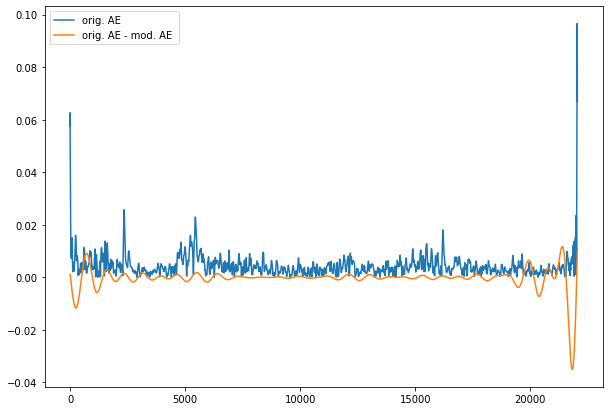

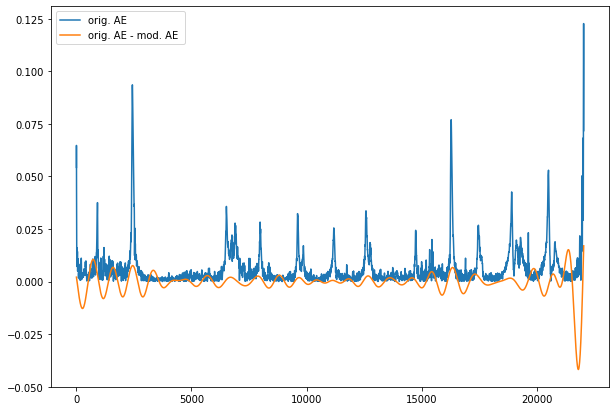

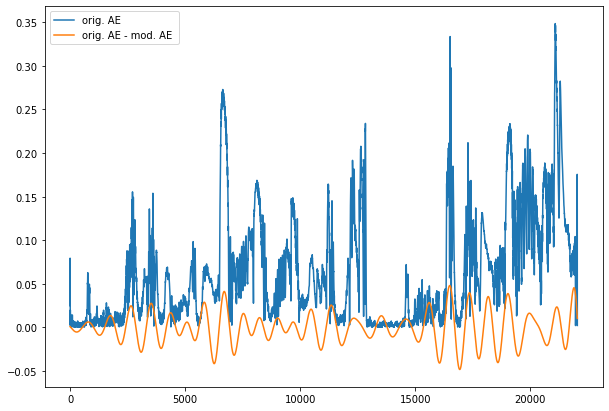

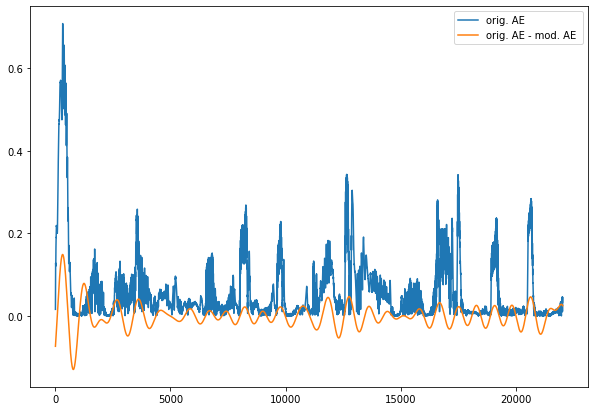

In [134]:
# this is the difference (in the time-amplitude domain) between the original signal and the bandstoped signal (i.e. signal with specific frequencies removed) for each frequency band
sig_removed = np.subtract(amp_env, amp_env_filtered)

plt.figure(figsize=(10,7))

for i in range(len(sig_removed)):
  plt.figure(figsize=(10,7))
  plt.plot(amp_env[i],label='orig. AE')
  plt.plot(sig_removed[i],label='orig. AE - mod. AE ')
  plt.legend()
  plt.show()

## 3.2 FFT of the diff signal

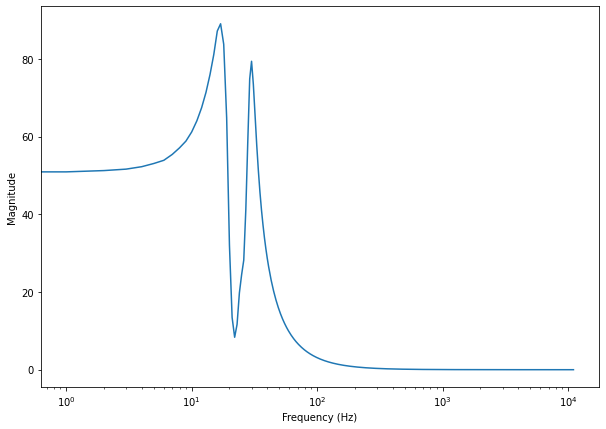

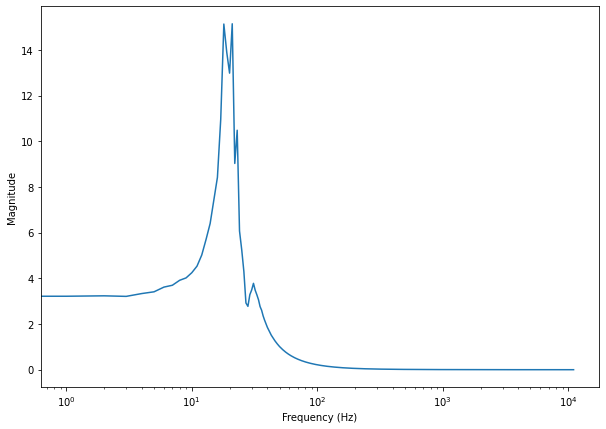

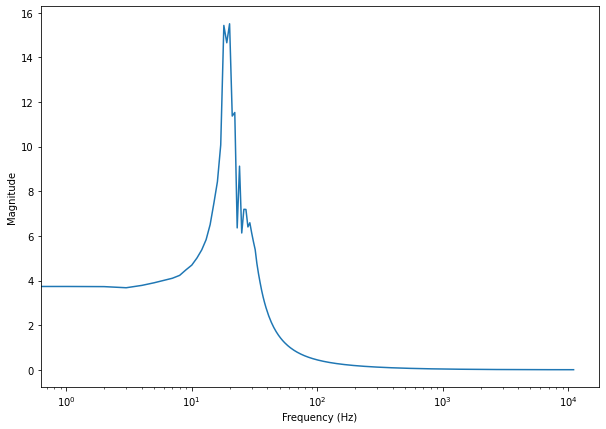

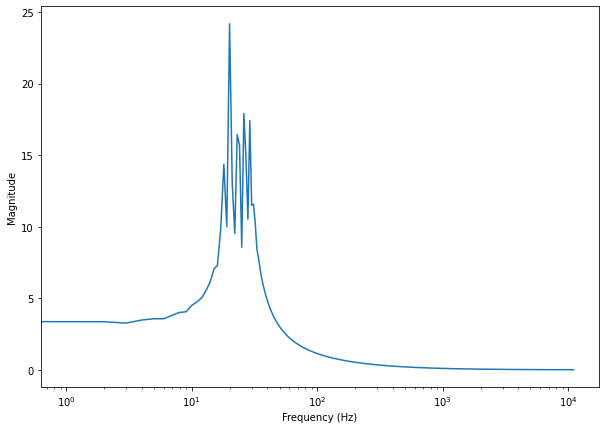

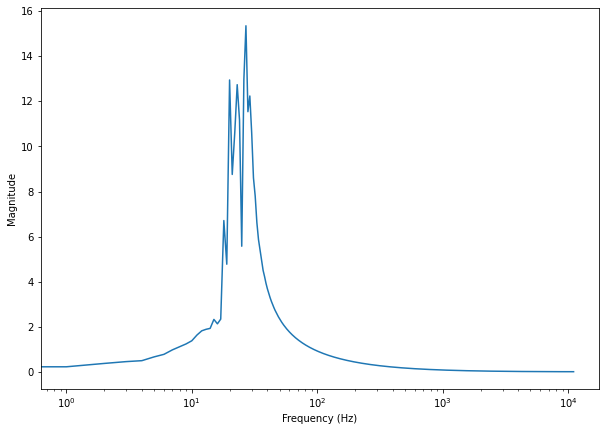

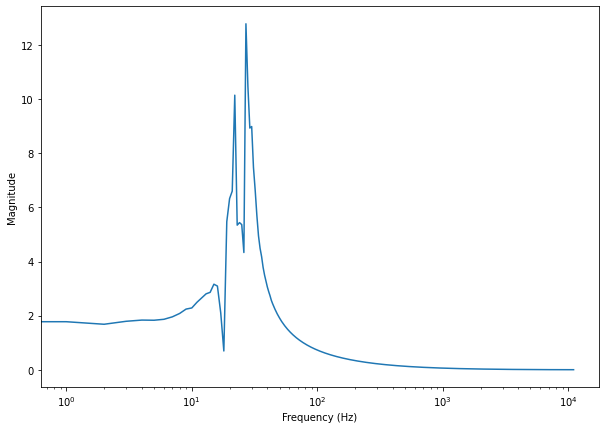

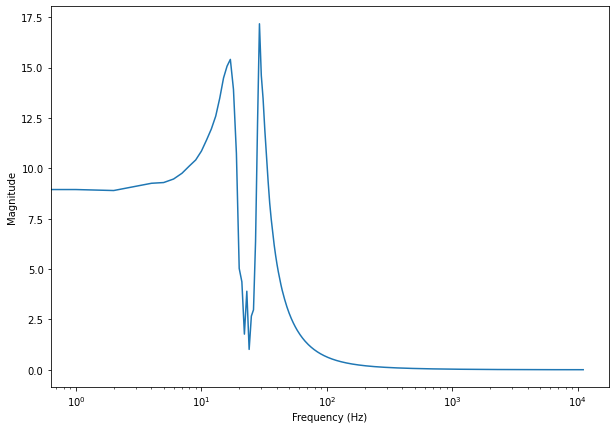

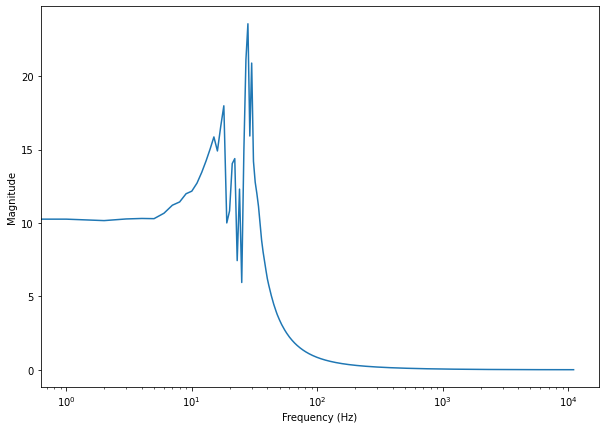

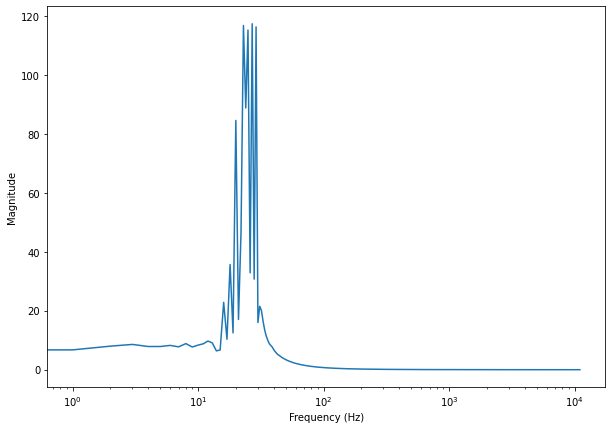

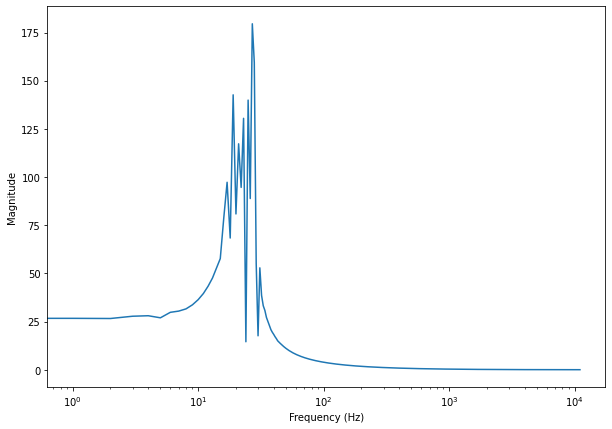

In [144]:
fft_sig_removed = []
for s in sig_removed:
  fft_sig_removed.append(scipy.fft.fft(s))
  fft_abs_sig_removed=np.abs(fft_sig_removed[-1])
  freq = np.linspace(0, sr, len(fft_abs_sig_removed)) 
    
  plt.figure(figsize=(10,7))

  plt.plot(freq[0:int(len(freq)/2)],fft_abs_sig_removed[0:int(len(freq)/2)])
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Magnitude")
  plt.xscale('log')
  #plt.yscale('log')
  plt.show()


  

##  3.3 Bank-filter the modified signal 

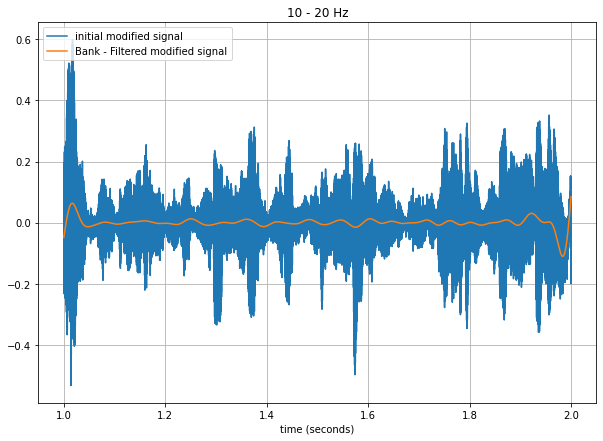

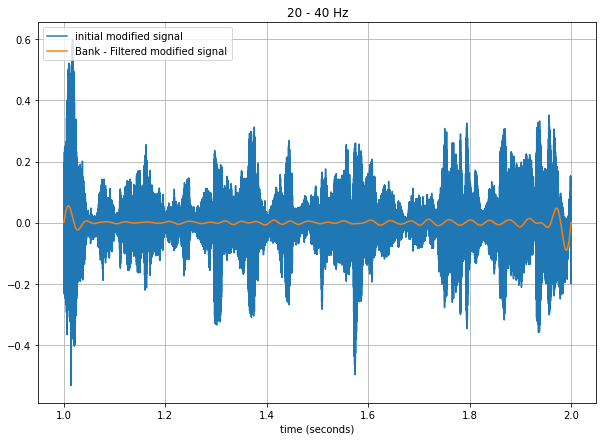

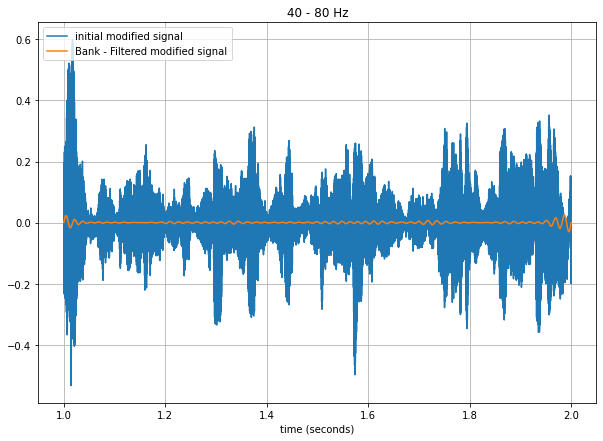

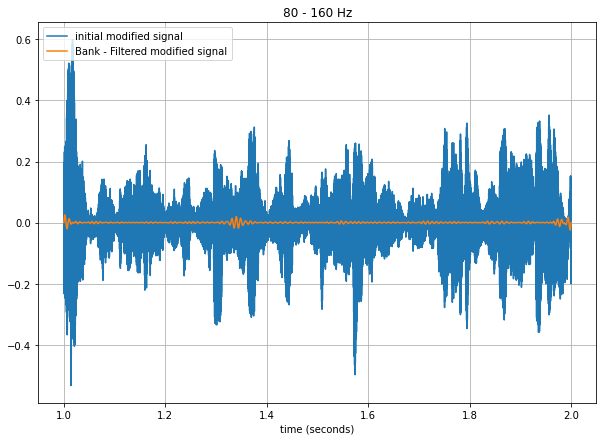

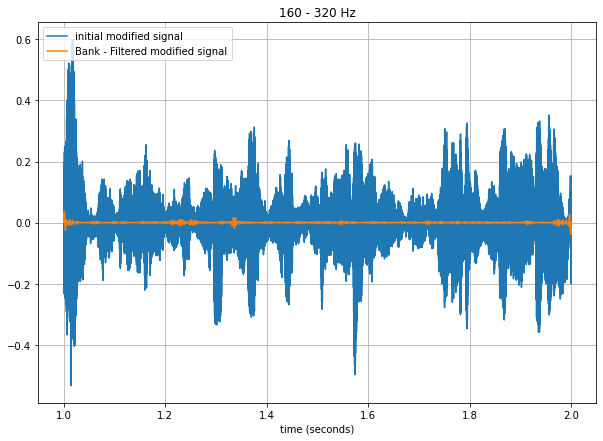

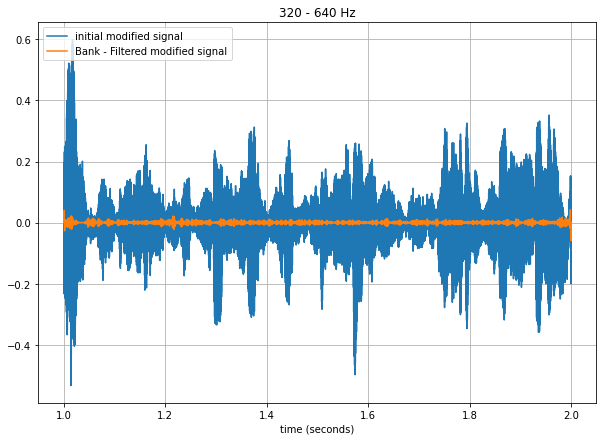

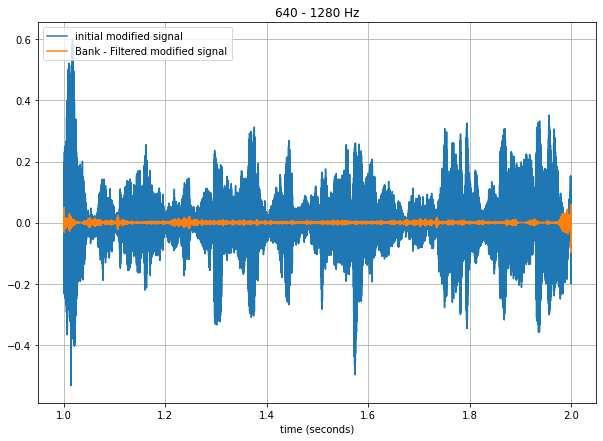

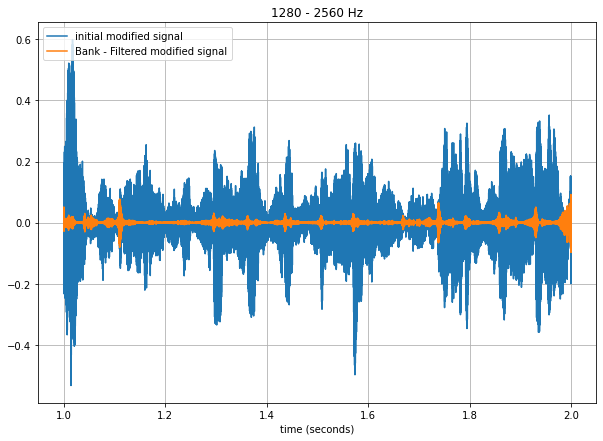

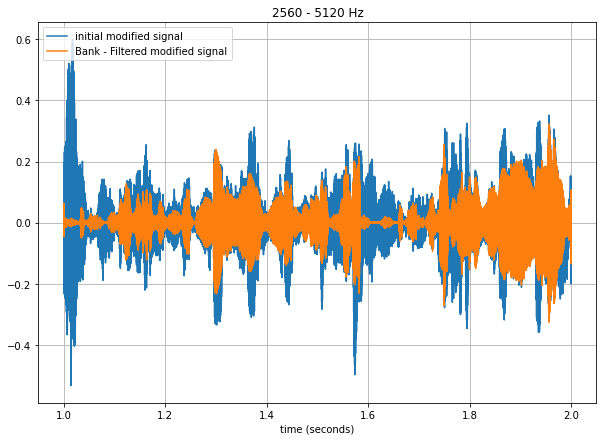

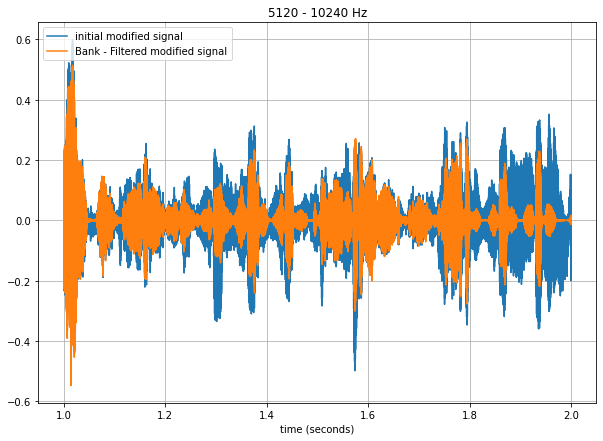

In [146]:
 # timepoints for the plots
t = np.linspace(signal_start, signal_start + signal_duration, len(signal), endpoint=False)


bp_mod_signal = []
for i in range(len(freqs)-1):
  lowcut = freqs[i]
  highcut = freqs[i+1]

  #bp_signal.append(butter_bandpass_filter(signal, lowcut, highcut, sr, order=6))
  bp_mod_signal.append(bandpass(mod_signal, sr, lowcut, highcut, bandwidth=50))

  plt.figure(figsize=(10,7))
  plt.clf()
  plt.plot(t, mod_signal, label='initial modified signal')
  plt.plot(t, bp_mod_signal[i], label='Bank - Filtered modified signal' )
  plt.xlabel('time (seconds)')
  plt.grid(True)
  plt.axis('tight')
  #plt.ylim([-1,1])
  plt.legend(loc='upper left')
  plt.title(str(lowcut)+' - '+str(highcut)+' Hz')
  plt.show()

## 3.4 Get AE of bank-filtered modified signal

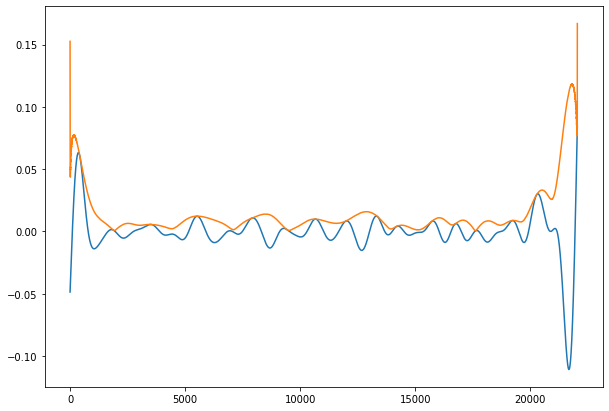

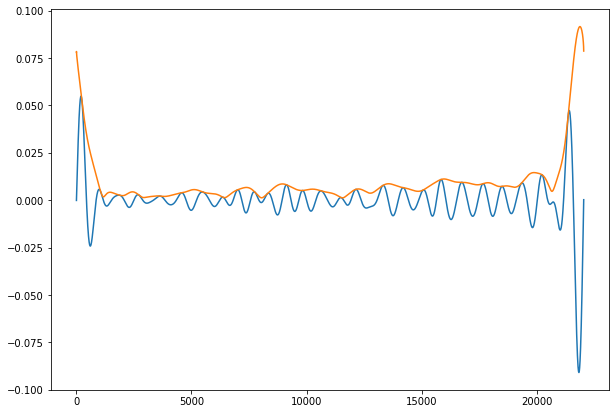

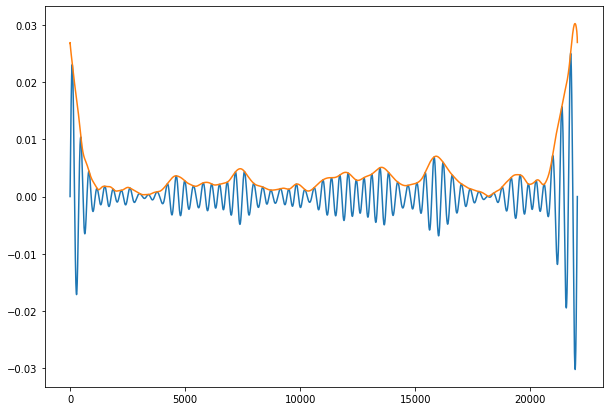

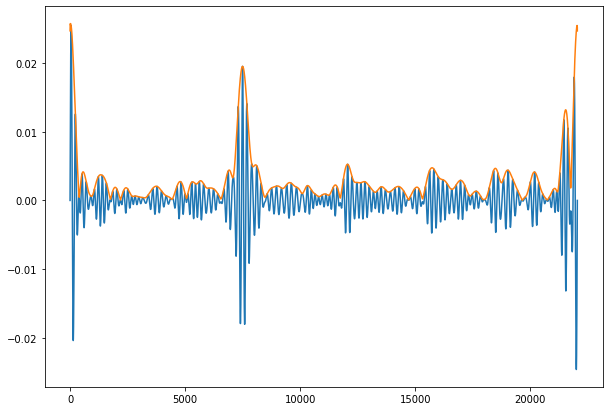

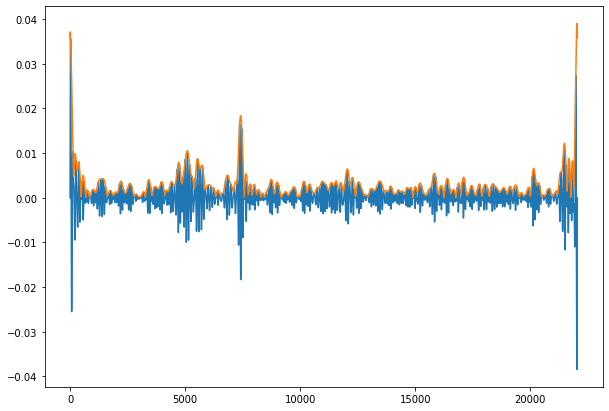

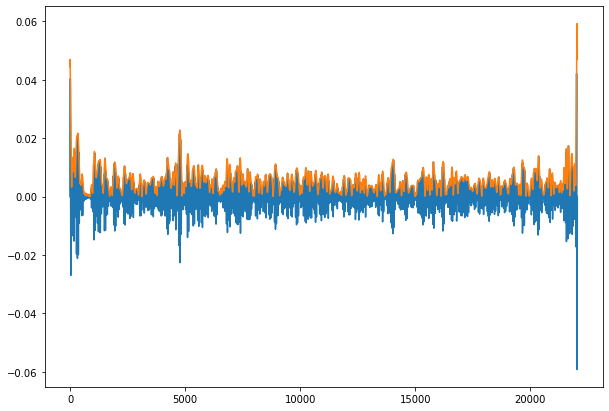

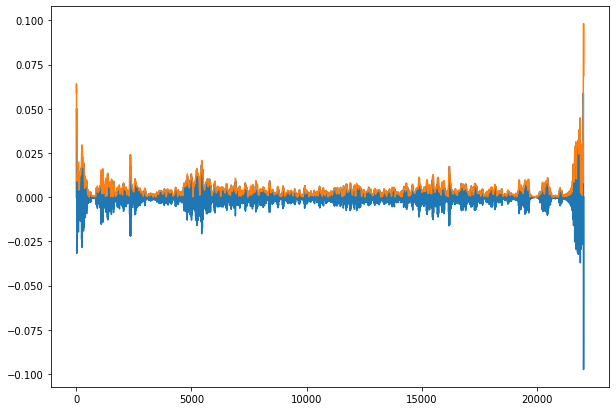

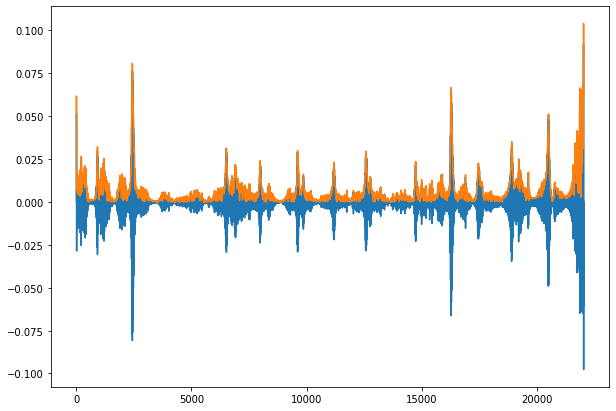

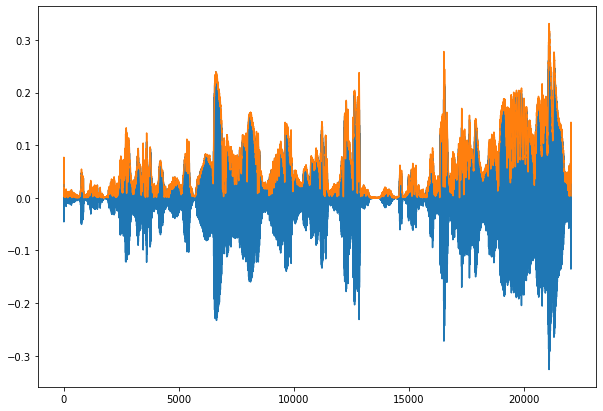

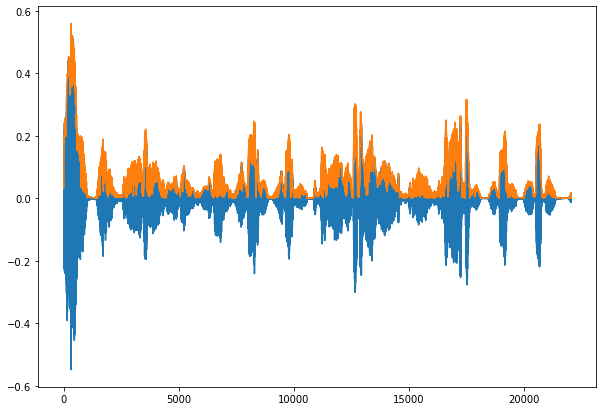

In [147]:
# get A.E. using hilbert transform
mod_amp_env = []
inst_phase = []
for s in bp_mod_signal:
  z = (hilbert(s)) #form the analytical signal
  mod_amp_env.append(np.abs(z)) #envelope extraction
  inst_phase.append(np.unwrap(np.angle(z)))#inst phase
  inst_freq = np.diff(inst_phase)/(2*np.pi)*sr #inst frequency

  plt.figure(figsize=(10,7))
  plt.plot(s)
  plt.plot(mod_amp_env[-1])
  #plt.ylim([-0.5,0.5])
  plt.show()

## 3.5 FFT AE of bank-filtered modified signal

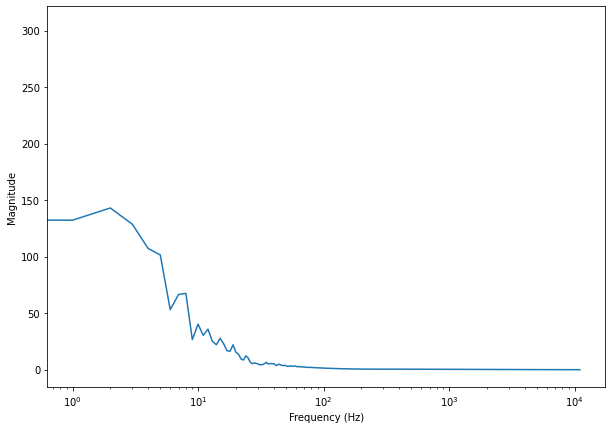

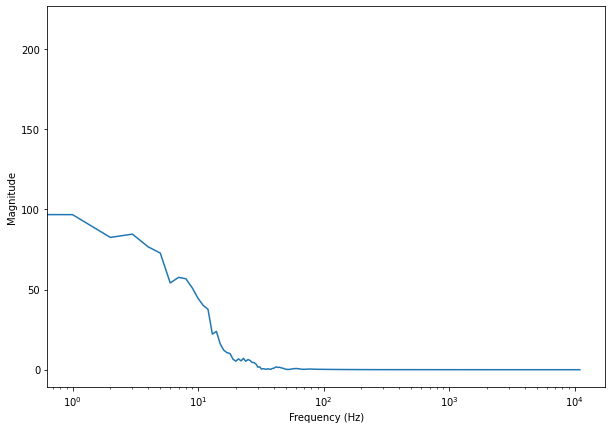

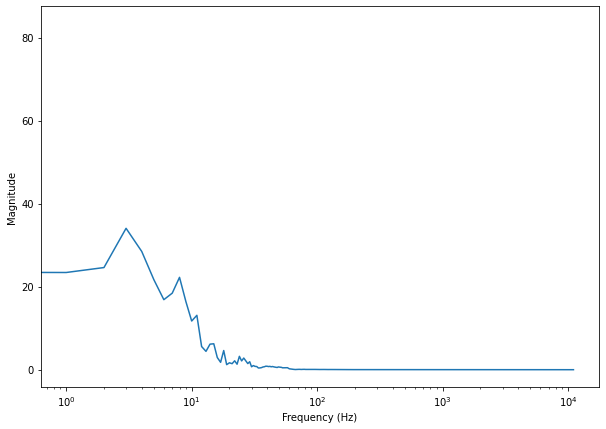

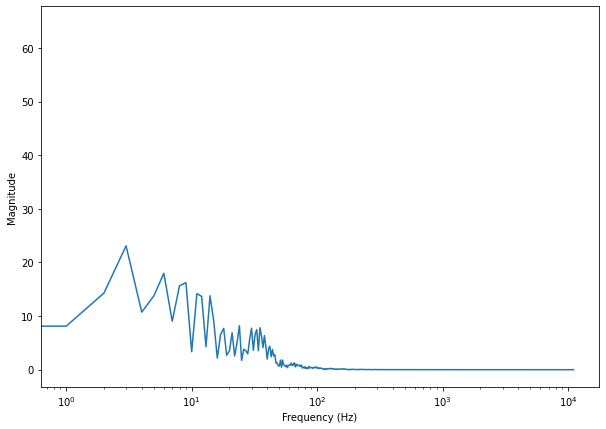

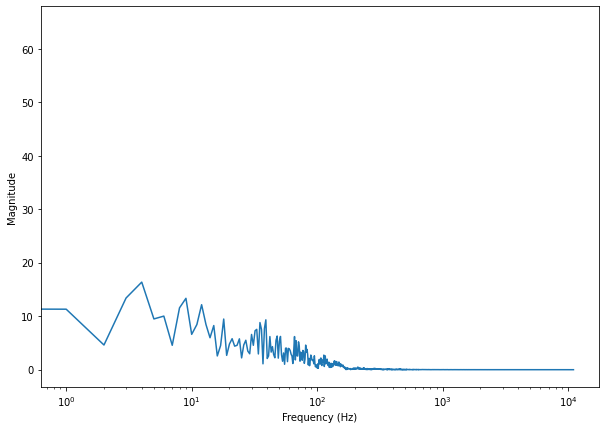

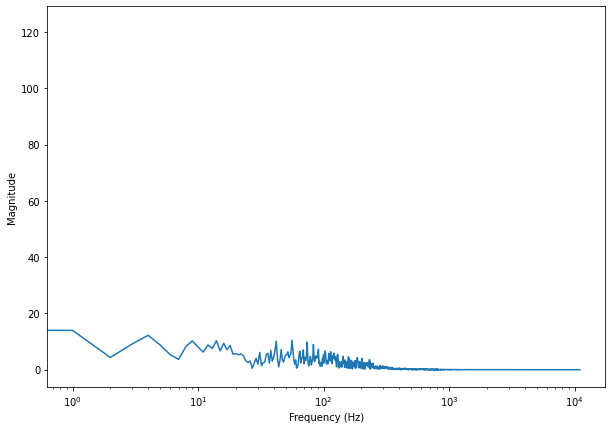

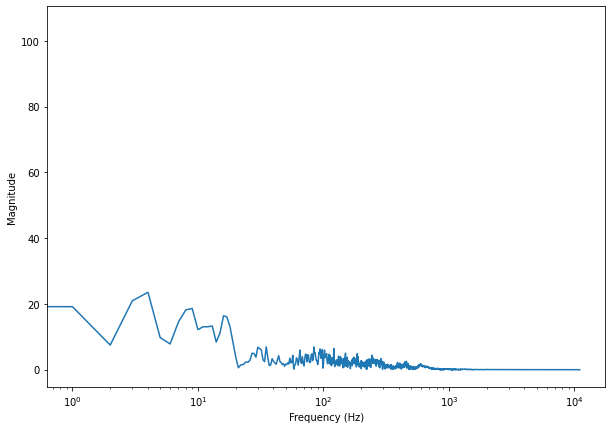

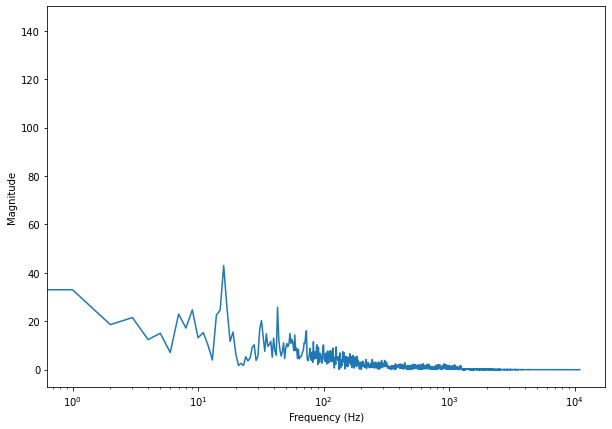

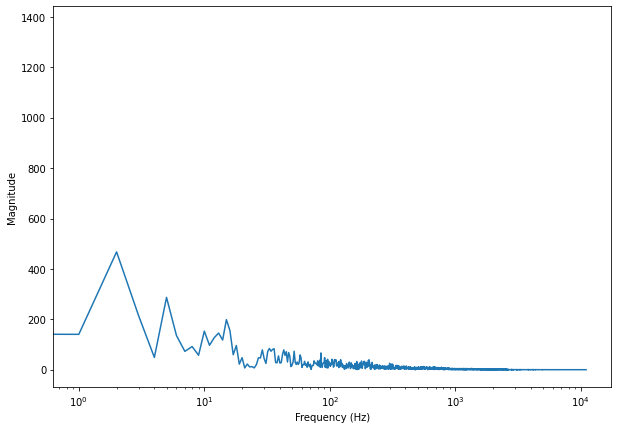

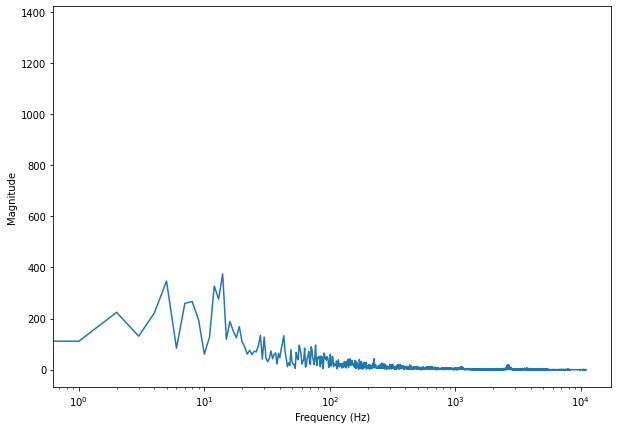

In [148]:
fft_mod_amp_env = []
for ae in mod_amp_env:
  fft_mod_amp_env.append(scipy.fft.fft(ae))
  fft_abs = np.abs(fft_mod_amp_env[-1])

  freq = np.linspace(0, sr, len(fft_abs)) 
    
  plt.figure(figsize=(10,7))

  plt.plot(freq[0:int(len(freq)/2)],fft_abs[0:int(len(freq)/2)])
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Magnitude")
  plt.xscale('log')
  #plt.yscale('log')
  plt.show()




## 3.6 Add fft of diff signal to fft of AE from mod signal and ifft back to time domain

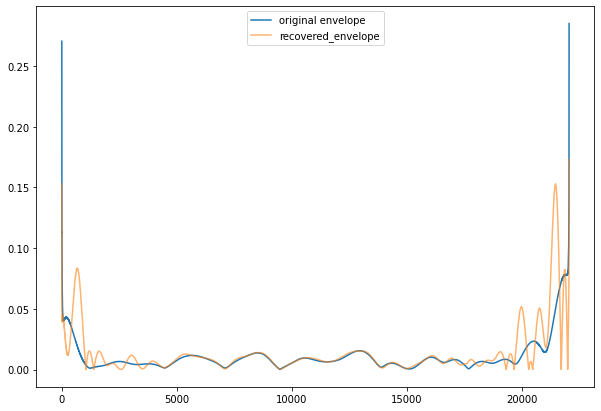

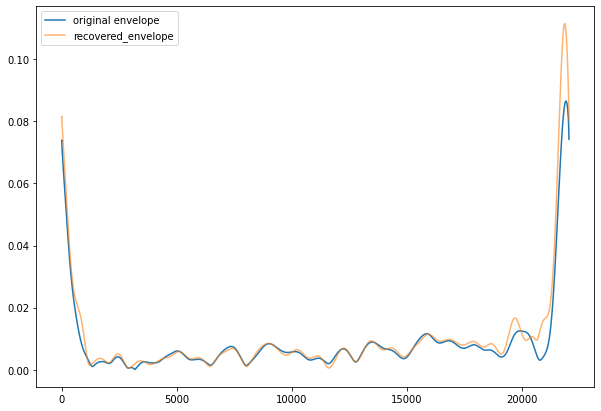

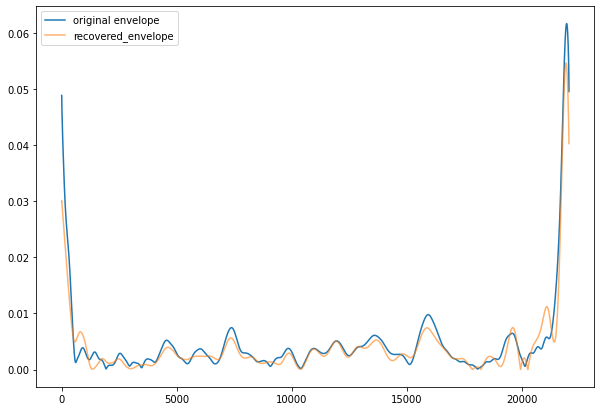

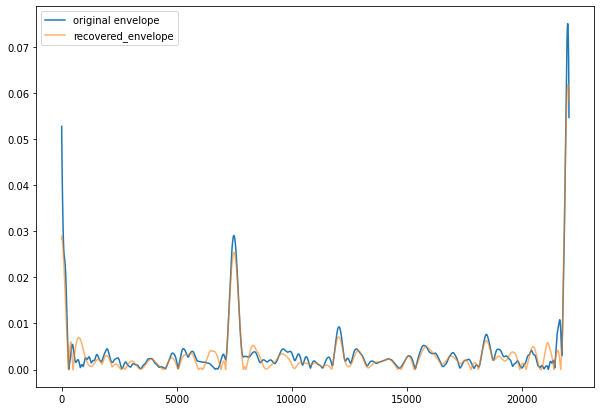

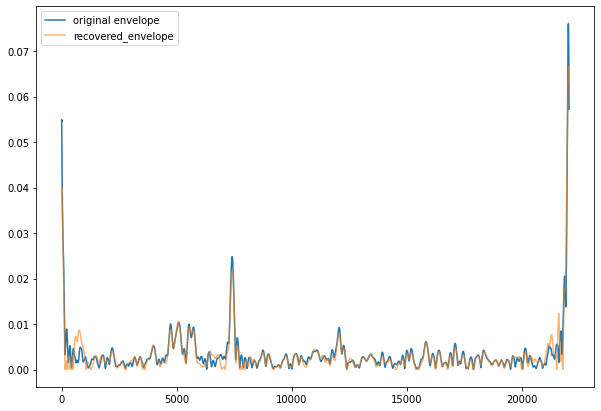

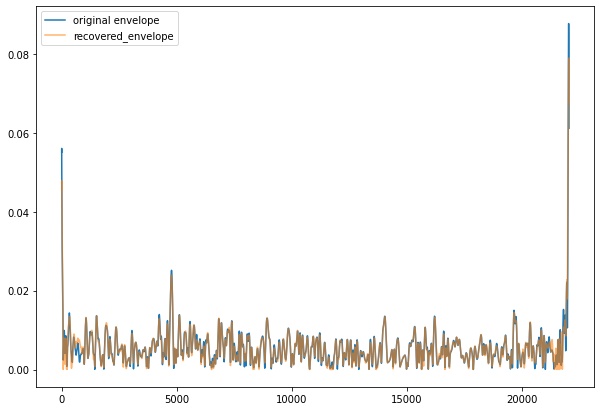

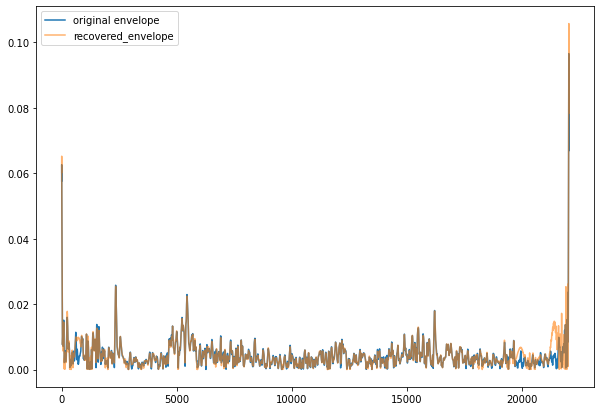

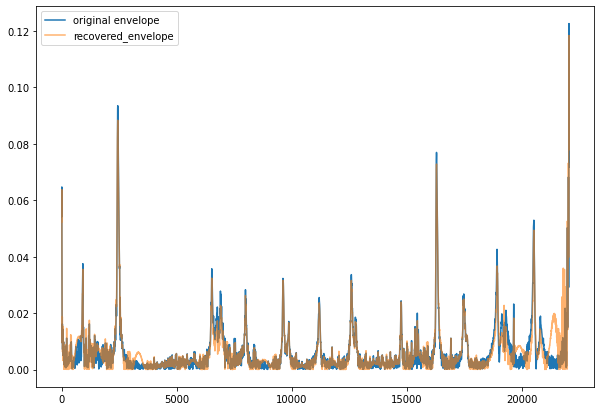

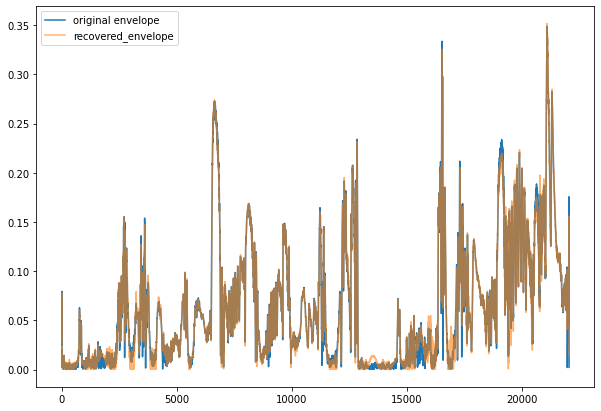

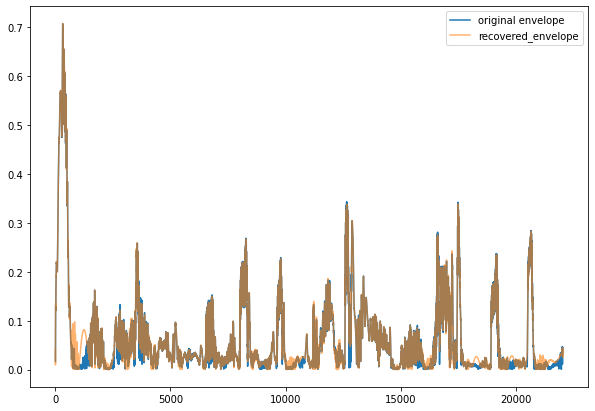

In [153]:

recovered_amp_env = []
for i in range(len(fft_mod_amp_env)):
  recovered_amp_env.append( scipy.fft.ifft(fft_mod_amp_env[i] + fft_sig_removed[i]))

  
  plt.figure(figsize=(10,7))
  plt.plot(amp_env[i],label='original envelope')
  plt.plot(np.abs(recovered_amp_env[i]),alpha=0.6,label='recovered_envelope')
  plt.legend()
  plt.show()


## 3.7 Put together the recovered signal

In [150]:
mod_envR = [i / j for i, j in zip(recovered_amp_env , mod_amp_env)] # calculate the ratio
recovered_bp_signal = [ i * j for i,j in zip(bp_mod_signal, mod_envR)] # multiply original audio with ratio


In [151]:
recovered_signal=sum(recovered_bp_signal)


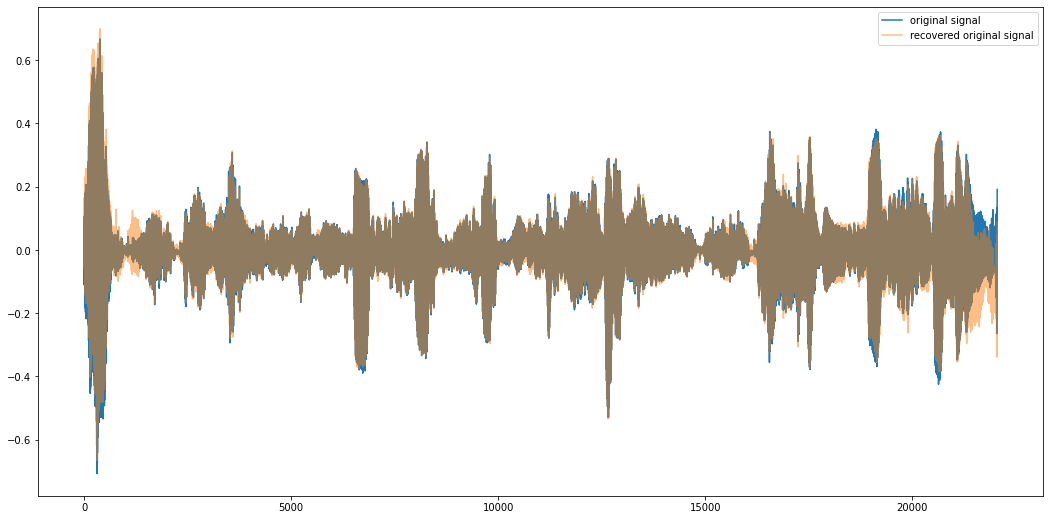

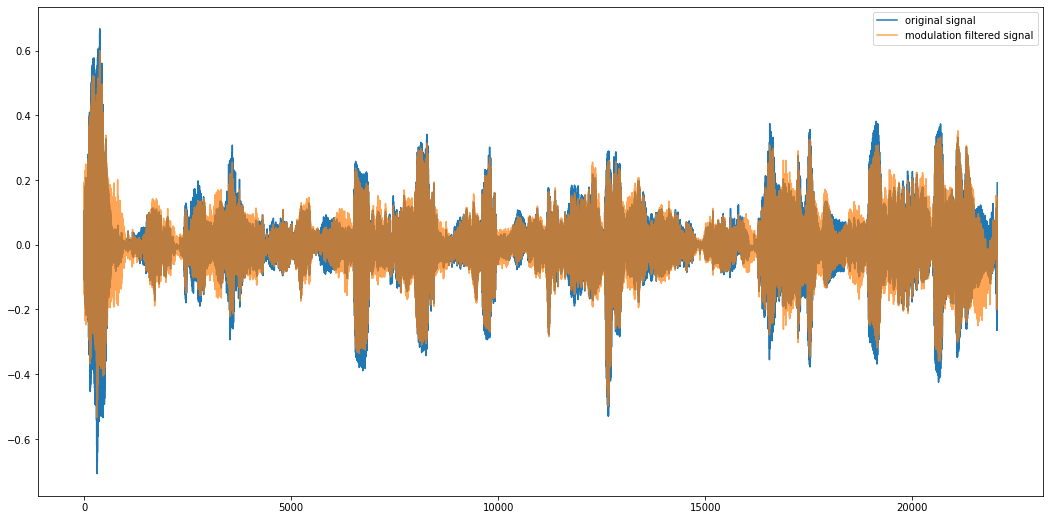

In [152]:
plt.figure(figsize=(18,9))
plt.plot(signal,label='original signal')
#plt.plot(mod_signal,label='modulation filtered signal',alpha = 0.7)
plt.plot(np.real(recovered_signal),alpha=0.5,label='recovered original signal')
plt.legend()
plt.show()

plt.figure(figsize=(18,9))
plt.plot(signal,label='original signal')
plt.plot(mod_signal,label='modulation filtered signal',alpha = 0.7)
#plt.plot(recovered_signal,alpha=0.5,label='recovered original signal')
plt.legend()
plt.show()

## 3.8 Check recovered signal

### 3.8.1 Compare spectrograms

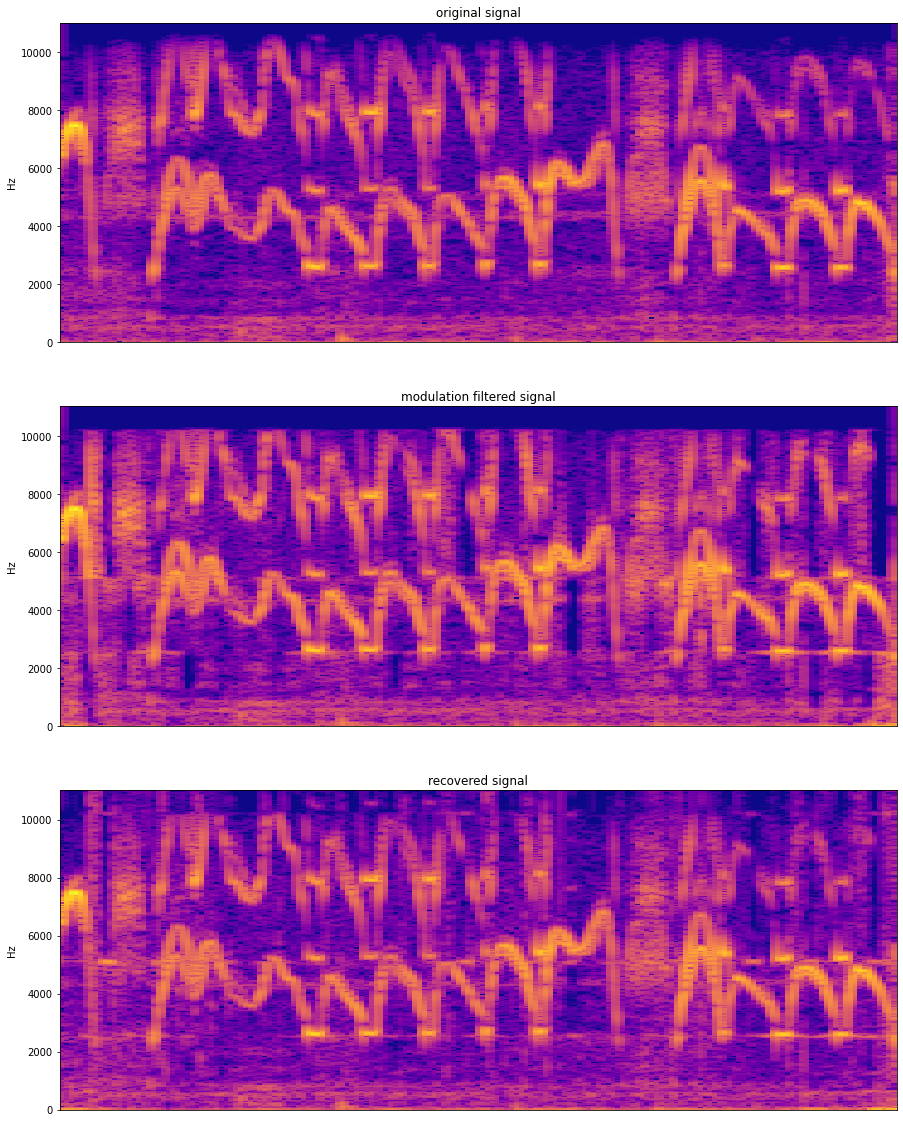

In [162]:
window_size = 1024
window_shift = 16
fig, ax = plt.subplots(nrows=3, sharex=False,gridspec_kw={'height_ratios': [1, 1,1]},figsize=(15,20))

#Original signal

stft = librosa.stft(signal,n_fft=512,hop_length=128)
spec_power = np.abs(stft)**2
p_to_db = librosa.power_to_db(spec_power)

librosa.display.specshow(p_to_db, sr=sr,y_axis='linear',ax = ax[0], cmap='plasma')
ax[0].set_title('original signal')

#modulated filtered signal

stft = librosa.stft(mod_signal,n_fft=512,hop_length=128)
spec_power = np.abs(stft)**2
p_to_db = librosa.power_to_db(spec_power)

librosa.display.specshow(p_to_db, sr=sr,y_axis='linear',ax = ax[1], cmap='plasma')
ax[1].set_title('modulation filtered signal')


#recovered signal

stft = librosa.stft(np.real(recovered_signal),n_fft=512,hop_length=128)
spec_power = np.abs(stft)**2
p_to_db = librosa.power_to_db(spec_power)

librosa.display.specshow(p_to_db, sr=sr,y_axis='linear',ax = ax[2], cmap='plasma')
ax[2].set_title('recovered signal')


plt.show()

### 3.8.2 Compare audio

In [154]:
print('ORIGINAL AUDIO CLIP')

Audio(data=signal,rate=sr)

ORIGINAL AUDIO CLIP


In [155]:
print('MODIFIED AUDIO CLIP')

Audio(data=mod_signal,rate=sr)

MODIFIED AUDIO CLIP


In [157]:
print('RECOVERED AUDIO CLIP')

Audio(data=np.real(recovered_signal),rate=sr)

RECOVERED AUDIO CLIP


### 3.8.3 Save recovered audio

In [164]:
# Give a name for the file to be saved
save_name = 'recovered.wav'

# write file (if in colab, remember to download it before leaving the session)
sf.write(save_name, np.real(recovered_signal), sr)

# General sandbox area

In [ ]:
ss=np.abs(mod_signal)**2
rms=np.sqrt(np.mean(ss))
print(rms)

0.10929770281008182


In [ ]:
ss=np.abs(signal)**2
rms=np.sqrt(np.mean(ss))
print(rms)

0.111552306


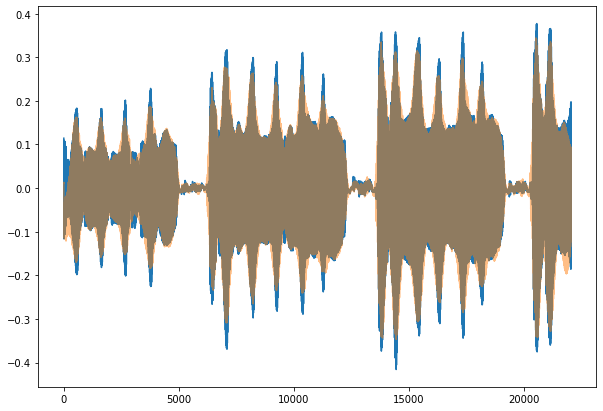

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(signal)
plt.plot(mod_signal*0.1116/0.1093,alpha=0.5)
plt.show()

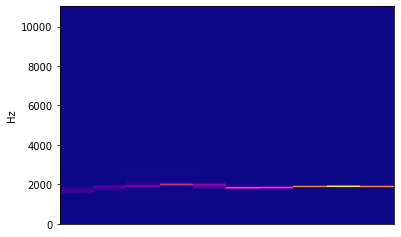

In [ ]:
librosa.display.specshow(spec_power[:,50:60], sr=sr,y_axis='linear', cmap='plasma')
plt.show()


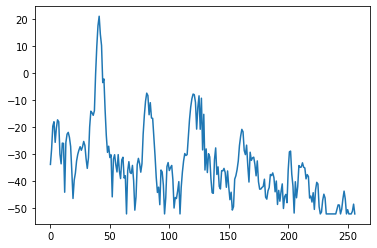

In [ ]:
plt.plot(p_to_db[:,12])

In [ ]:
test = np.fft.fft(np.abs(p_to_db[:,10]))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


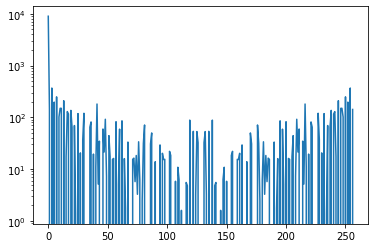

In [ ]:
plt.plot(test)
plt.yscale('log')